In [1]:
import pandas as pd
import numpy as np
from arcgis.features import GeoAccessor, GeoSeriesAccessor
from arcgis.geometry import Geometry, SpatialReference
from arcgis import geometry
from arcgis.gis import GIS
import arcpy
import os
import datetime
from pathlib import Path

In [17]:
#: WARNING: if you do this twice with the same geometry, you may overwrite the other column and lose it forever. 
#: I haven't tested that yet.

def _change_geometry(df, new_geometry_column, name_for_current):
    df[name_for_current] = df['SHAPE']
    df['SHAPE'] = df[new_geometry_column]
    df.spatial.set_geometry('SHAPE')
    df.spatial.sindex(reset=True)  #: not sure how necessary this is, but for safety's sake

In [18]:
def _dissolve_duplicate_parcels(parcels_for_modeling_layer):
    # dissolve on parcel id,summarizing attributes in various ways
    parcels_dissolved = 'memory/dissolved'
    if arcpy.Exists(parcels_dissolved):
        arcpy.management.Delete(parcels_dissolved)
    arcpy.management.Dissolve(
        parcels_for_modeling_layer, parcels_dissolved, 'PARCEL_ID', [
            ['PARCEL_ID', 'COUNT'],
            ['TAXEXEMPT_TYPE', 'FIRST'],
            ['TOTAL_MKT_VALUE', 'SUM'],
            ['LAND_MKT_VALUE', 'SUM'],
            ['PARCEL_ACRES', 'SUM'],
            ['PROP_CLASS', 'FIRST'],
            ['PRIMARY_RES', 'FIRST'],
            ['HOUSE_CNT', 'MAX'],
            ['BLDG_SQFT', 'SUM'],
            ['FLOORS_CNT', 'MAX'],
            ['BUILT_YR', 'FIRST'],
            ['EFFBUILT_YR', 'FIRST'],
        ], 'MULTI_PART', 'DISSOLVE_LINES'
    )

    # rename columns
    #: moves OBJECTID to first column
    parcels_dissolved_sdf = pd.DataFrame.spatial.from_featureclass(parcels_dissolved)
    parcels_dissolved_sdf.columns = [
        'OBJECTID',
        'PARCEL_ID',
        'COUNT_PARCEL_ID',
        'TAXEXEMPT_TYPE',
        'TOTAL_MKT_VALUE',
        'LAND_MKT_VALUE',
        'PARCEL_ACRES',
        'PROP_CLASS',
        'PRIMARY_RES',
        'HOUSE_CNT',
        'BLDG_SQFT',
        'FLOORS_CNT',
        'BUILT_YR',
        'EFFBUILT_YR',
        'SHAPE',
    ]

    # remove parcels without parcel ids
    # parcels_dissolved_sdf = parcels_dissolved_sdf[parcels_dissolved_sdf['PARCEL_ID'].isnull() == False].copy()
    # parcels_dissolved_sdf = parcels_dissolved_sdf[parcels_dissolved_sdf['PARCEL_ID'].notnull()].copy()
    parcels_dissolved_sdf.dropna(subset=['PARCEL_ID'], inplace=True)

    return parcels_dissolved_sdf

In [19]:
def _add_centroids_to_parcel_df(parcels_df, join_field):
    memory_parcels = 'memory/parcels'
    memory_centroids = 'memory/centroids'

    for featureclass in [memory_centroids, memory_parcels]:
        if arcpy.Exists(featureclass):
            arcpy.management.Delete(featureclass)

    print('writing parcels to fc')
    parcels_df.spatial.to_featureclass(memory_parcels)
    print('feature to point')
    arcpy.management.FeatureToPoint(memory_parcels, memory_centroids, 'INSIDE')
    print('reading centroids to df')
    centroids_df = (
        pd.DataFrame.spatial.from_featureclass(memory_centroids)[[join_field.lower(), 'SHAPE']]
        .rename(columns={'SHAPE':'CENTROIDS', join_field.lower(): join_field})
        .assign(**{join_field:lambda df: df[join_field].astype(str)})
    )    

    print(centroids_df.dtypes)
    print('joining back')
    joined_df = parcels_df.merge(centroids_df, on=join_field, how='left')

    blank_centroids = joined_df['CENTROIDS'].isna().sum()
    if blank_centroids:
        print(f'{blank_centroids} blank centroids!')

    return joined_df

# Join test

In [4]:
areas_fc = r'c:/gis/projects/udoh/udoh.gdb/SmallStatisticalAreas_2018'
tracts_fc = r'C:\Users\jdadams\AppData\Roaming\Esri\ArcGISPro\Favorites\opensgid.agrc.utah.gov.sde\opensgid.demographic.census_tracts_2020'

In [25]:
areas_df = pd.DataFrame.spatial.from_featureclass(areas_fc)
tracts_df = pd.DataFrame.spatial.from_featureclass(tracts_fc)

In [6]:
tracts_df['CENTROIDS'] = tracts_df['SHAPE'].apply(
    lambda shape: Geometry({
        'x': shape.centroid[0],
        'y': shape.centroid[1],
        'spatialReference': shape.spatial_reference
    })
)

In [18]:
m1 = GIS().map()
m1.add_layer(tracts_df)
m1.add_layer(areas_df)
m1

MapView(layout=Layout(height='400px', width='100%'))

In [7]:
_change_geometry(tracts_df, 'CENTROIDS', 'POLYS')

In [8]:
joined_df = tracts_df.spatial.join(areas_df, 'left', 'within')

In [9]:
joined_df

,xid,statefp20,countyfp20,tractce20,geoid20,name20,namelsad20,mtfcc20,funcstat20,aland20,awater20,intptlat20,intptlon20,SHAPE,CENTROIDS,POLYS,index_right,OBJECTID,smallareanumber,smallareaname
0,1,49,049,000901,49049000901,9.01,Census Tract,G5020,S,1.686016e+06,0.0,+40.3051285,-111.6922978,"{""x"": 441169.29876317625, ""y"": 4461854.3007924...","{'x': 441169.29876317625, 'y': 4461854.3007924...","{""rings"": [[[440398.4642000003, 4462604.4892],...",59.0,63.0,44,Orem (North)
1,2,49,049,002500,49049002500,25,Census Tract,G5020,S,1.034541e+06,0.0,+40.2296149,-111.6497278,"{""x"": 444725.4420491648, ""y"": 4453445.15503423...","{'x': 444725.4420491648, 'y': 4453445.15503423...","{""rings"": [[[444113.66309999954, 4453163.1712]...",64.0,68.0,48.2,Provo (East City Center)
2,3,49,049,003401,49049003401,34.01,Census Tract,G5020,S,9.085765e+06,23788.0,+40.0560227,-111.7122570,"{""x"": 439257.47857315646, ""y"": 4434122.5080396...","{'x': 439257.47857315646, 'y': 4434122.5080396...","{""rings"": [[[436447.3992999997, 4432868.571], ...",71.0,75.0,50.2,Payson
3,4,49,049,010210,49049010210,102.10,Census Tract,G5020,S,1.581048e+07,0.0,+40.4005884,-111.7306856,"{""x"": 437994.61392989865, ""y"": 4472476.4166772...","{'x': 437994.61392989865, 'y': 4472476.4166772...","{""rings"": [[[434385.5806999998, 4474166.1998],...",58.0,62.0,43,Pleasant Grove/Lindon
4,5,49,049,000505,49049000505,5.05,Census Tract,G5020,S,3.919712e+06,0.0,+40.3700595,-111.7070846,"{""x"": 439970.29811329854, ""y"": 4469071.4450746...","{'x': 439970.29811329854, 'y': 4469071.4450746...","{""rings"": [[[438303.71279999986, 4469684.0035]...",58.0,62.0,43,Pleasant Grove/Lindon
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
711,712,49,035,111701,49035111701,1117.01,Census Tract,G5020,S,1.358256e+06,0.0,+40.6934670,-111.8826082,"{""x"": 425428.02143853245, ""y"": 4505104.4082948...","{'x': 425428.02143853245, 'y': 4505104.4082948...","{""rings"": [[[424945.5695000002, 4504747.2454],...",23.0,27.0,25,South Salt Lake
712,713,49,035,111903,49035111903,1119.03,Census Tract,G5020,S,2.072253e+06,0.0,+40.6806830,-111.8627470,"{""x"": 427092.1915410602, ""y"": 4503668.64664819...","{'x': 427092.1915410602, 'y': 4503668.64664819...","{""rings"": [[[426353.4841, 4503135.8453], [4263...",25.0,29.0,26.2,Millcreek (South)
713,714,49,035,111905,49035111905,1119.05,Census Tract,G5020,S,1.167718e+06,0.0,+40.6765749,-111.8744366,"{""x"": 426099.79680161, ""y"": 4503222.390862818,...","{'x': 426099.79680161, 'y': 4503222.390862818,...","{""rings"": [[[425548.92899999954, 4502917.7248]...",34.0,38.0,31,Murray
714,715,49,035,113309,49035113309,1133.09,Census Tract,G5020,S,1.867612e+06,0.0,+40.6881369,-111.9693980,"{""x"": 418088.48904618004, ""y"": 4504590.0128683...","{'x': 418088.48904618004, 'y': 4504590.0128683...","{""rings"": [[[417449.58469999954, 4505538.77260...",20.0,24.0,23.1,West Valley (East) V2


In [50]:
joined_df[joined_df.isna().any(axis=1)].shape[0]  #:Number of rows with nan values

1

In [51]:
joined_df[joined_df['smallareaname'].notna()]

,xid,statefp20,countyfp20,tractce20,geoid20,name20,namelsad20,mtfcc20,funcstat20,aland20,awater20,intptlat20,intptlon20,SHAPE,CENTROIDS,POLYS,index_right,OBJECTID,smallareanumber,smallareaname
0,1,49,049,000901,49049000901,9.01,Census Tract,G5020,S,1.686016e+06,0.0,+40.3051285,-111.6922978,"{""x"": 441169.29876317625, ""y"": 4461854.3007924...","{'x': 441169.29876317625, 'y': 4461854.3007924...","{""rings"": [[[440398.4642000003, 4462604.4892],...",59.0,63.0,44,Orem (North)
1,2,49,049,002500,49049002500,25,Census Tract,G5020,S,1.034541e+06,0.0,+40.2296149,-111.6497278,"{""x"": 444725.4420491648, ""y"": 4453445.15503423...","{'x': 444725.4420491648, 'y': 4453445.15503423...","{""rings"": [[[444113.66309999954, 4453163.1712]...",64.0,68.0,48.2,Provo (East City Center)
2,3,49,049,003401,49049003401,34.01,Census Tract,G5020,S,9.085765e+06,23788.0,+40.0560227,-111.7122570,"{""x"": 439257.47857315646, ""y"": 4434122.5080396...","{'x': 439257.47857315646, 'y': 4434122.5080396...","{""rings"": [[[436447.3992999997, 4432868.571], ...",71.0,75.0,50.2,Payson
3,4,49,049,010210,49049010210,102.10,Census Tract,G5020,S,1.581048e+07,0.0,+40.4005884,-111.7306856,"{""x"": 437994.61392989865, ""y"": 4472476.4166772...","{'x': 437994.61392989865, 'y': 4472476.4166772...","{""rings"": [[[434385.5806999998, 4474166.1998],...",58.0,62.0,43,Pleasant Grove/Lindon
4,5,49,049,000505,49049000505,5.05,Census Tract,G5020,S,3.919712e+06,0.0,+40.3700595,-111.7070846,"{""x"": 439970.29811329854, ""y"": 4469071.4450746...","{'x': 439970.29811329854, 'y': 4469071.4450746...","{""rings"": [[[438303.71279999986, 4469684.0035]...",58.0,62.0,43,Pleasant Grove/Lindon
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
711,712,49,035,111701,49035111701,1117.01,Census Tract,G5020,S,1.358256e+06,0.0,+40.6934670,-111.8826082,"{""x"": 425428.02143853245, ""y"": 4505104.4082948...","{'x': 425428.02143853245, 'y': 4505104.4082948...","{""rings"": [[[424945.5695000002, 4504747.2454],...",23.0,27.0,25,South Salt Lake
712,713,49,035,111903,49035111903,1119.03,Census Tract,G5020,S,2.072253e+06,0.0,+40.6806830,-111.8627470,"{""x"": 427092.1915410602, ""y"": 4503668.64664819...","{'x': 427092.1915410602, 'y': 4503668.64664819...","{""rings"": [[[426353.4841, 4503135.8453], [4263...",25.0,29.0,26.2,Millcreek (South)
713,714,49,035,111905,49035111905,1119.05,Census Tract,G5020,S,1.167718e+06,0.0,+40.6765749,-111.8744366,"{""x"": 426099.79680161, ""y"": 4503222.390862818,...","{'x': 426099.79680161, 'y': 4503222.390862818,...","{""rings"": [[[425548.92899999954, 4502917.7248]...",34.0,38.0,31,Murray
714,715,49,035,113309,49035113309,1133.09,Census Tract,G5020,S,1.867612e+06,0.0,+40.6881369,-111.9693980,"{""x"": 418088.48904618004, ""y"": 4504590.0128683...","{'x': 418088.48904618004, 'y': 4504590.0128683...","{""rings"": [[[417449.58469999954, 4505538.77260...",20.0,24.0,23.1,West Valley (East) V2


In [10]:
joined_inner_df = tracts_df.spatial.join(areas_df, 'inner', 'within')

In [11]:
joined_inner_df

,xid,statefp20,countyfp20,tractce20,geoid20,name20,namelsad20,mtfcc20,funcstat20,aland20,awater20,intptlat20,intptlon20,SHAPE,CENTROIDS,POLYS,index_right,OBJECTID,smallareanumber,smallareaname
0,1,49,049,000901,49049000901,9.01,Census Tract,G5020,S,1.686016e+06,0.0,+40.3051285,-111.6922978,"{""x"": 441169.29876317625, ""y"": 4461854.3007924...","{'x': 441169.29876317625, 'y': 4461854.3007924...","{'rings': [[[440398.4642000003, 4462604.4892],...",59,63,44,Orem (North)
1,13,49,049,000703,49049000703,7.03,Census Tract,G5020,S,1.831747e+06,0.0,+40.3156465,-111.6899270,"{""x"": 441379.8662237534, ""y"": 4463020.20262828...","{'x': 441379.8662237534, 'y': 4463020.20262828...","{'rings': [[[440128.60699999984, 4463430.2863]...",59,63,44,Orem (North)
2,123,49,049,000707,49049000707,7.07,Census Tract,G5020,S,1.532480e+06,0.0,+40.3258061,-111.7137593,"{""x"": 439364.00949996844, ""y"": 4464163.9476659...","{'x': 439364.00949996844, 'y': 4464163.9476659...","{'rings': [[[438670.8861999996, 4464615.9099],...",59,63,44,Orem (North)
3,124,49,049,000801,49049000801,8.01,Census Tract,G5020,S,1.833326e+06,0.0,+40.3081523,-111.7127586,"{""x"": 439433.2507907797, ""y"": 4462203.73230499...","{'x': 439433.2507907797, 'y': 4462203.73230499...","{'rings': [[[438328.6040000003, 4462625.9417],...",59,63,44,Orem (North)
4,125,49,049,000706,49049000706,7.06,Census Tract,G5020,S,2.184751e+06,0.0,+40.3177123,-111.7170691,"{""x"": 439075.5541741788, ""y"": 4463267.82426487...","{'x': 439075.5541741788, 'y': 4463267.82426487...","{'rings': [[[437849.7767000003, 4464232.577500...",59,63,44,Orem (North)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
710,716,49,015,976500,49015976500,9765,Census Tract,G5020,S,8.782568e+09,14165655.0,+38.9311083,-110.6644589,"{""x"": 531221.4397219317, ""y"": 4305075.81417691...","{'x': 531221.4397219317, 'y': 4305075.81417691...","{'rings': [[[473273.6588000003, 4276684.8684],...",83,87,56.2,Emery County
711,651,49,037,978200,49037978200,9782,Census Tract,G5020,S,9.296421e+09,192709561.0,+37.6174788,-109.9834213,"{""x"": 589598.9234787896, ""y"": 4162715.97376665...","{'x': 589598.9234787896, 'y': 4162715.97376665...","{'rings': [[[508811.7142000003, 4114325.200899...",86,90,57.4,San Juan County (Other)
712,652,49,037,942100,49037942100,9421,Census Tract,G5020,S,2.962764e+09,74416830.0,+37.1031945,-110.3979381,"{""x"": 553426.9994610251, ""y"": 4107382.06255905...","{'x': 553426.9994610251, 'y': 4107382.06255905...","{'rings': [[[463282.94570000004, 4095174.705],...",86,90,57.4,San Juan County (Other)
713,654,49,037,942000,49037942000,9420,Census Tract,G5020,S,2.220605e+09,8760375.0,+37.1948026,-109.3389774,"{""x"": 646718.0546056273, ""y"": 4116071.81085491...","{'x': 646718.0546056273, 'y': 4116071.81085491...","{'rings': [[[612062.9029999999, 4111103.7786],...",86,90,57.4,San Juan County (Other)


In [12]:
joined_inner_df.groupby('smallareaname')['aland20'].sum()

smallareaname
Alpine                          8.864834e+07
American Fork                   5.599178e+07
Ben Lomond                      3.395271e+08
Blanding/Monticello             5.773384e+09
Bountiful                       9.298409e+07
                                    ...     
West Jordan (West)/Copperton    2.316268e+07
West Valley (Center)            1.631328e+07
West Valley (East) V2           2.805217e+07
West Valley (West) V2           3.281206e+07
Woods Cross/West Bountiful      3.164638e+07
Name: aland20, Length: 99, dtype: float64

In [44]:
areas_inner_df = areas_df.spatial.join(tracts_df, 'inner', 'contains')
aland_sum = areas_inner_df.groupby('smallareaname')['aland20'].sum()
awater_sum = areas_inner_df.groupby('smallareaname')['awater20'].sum()

In [60]:
combo_df = areas_df.copy()

In [69]:
combo_df.sort_values(by='smallareaname', inplace=True)
combo_df

,OBJECTID,smallareanumber,smallareaname,SHAPE
57,61,42.2,Alpine,"{""rings"": [[[439836.0700000003, 4487116.82], [..."
56,60,42.1,American Fork,"{""rings"": [[[439487.78000000026, 4479946.93], ..."
69,73,5,Ben Lomond,"{""rings"": [[[405343.53000000026, 4576771.42], ..."
85,89,57.3,Blanding/Monticello,"{""rings"": [[[647234.3200000003, 4242568.18], [..."
10,14,16,Bountiful,"{""rings"": [[[433248, 4530334.6], [433240, 4530..."
...,...,...,...,...
38,42,34.2,West Jordan (West)/Copperton,"{""rings"": [[[408316.4400000004, 4501536.75], [..."
18,22,22.1,West Valley (Center),"{""rings"": [[[417478.2999999998, 4508850.199999..."
20,24,23.1,West Valley (East) V2,"{""rings"": [[[423261.2400000002, 4508781.26], [..."
19,23,22.2,West Valley (West) V2,"{""rings"": [[[413492.6500000004, 4508812.74], [..."


In [74]:
tracts_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 716 entries, 0 to 715
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   xid         716 non-null    int64   
 1   statefp20   716 non-null    object  
 2   countyfp20  716 non-null    object  
 3   tractce20   716 non-null    object  
 4   geoid20     716 non-null    object  
 5   name20      716 non-null    object  
 6   namelsad20  716 non-null    object  
 7   mtfcc20     716 non-null    object  
 8   funcstat20  716 non-null    object  
 9   aland20     716 non-null    float64 
 10  awater20    716 non-null    float64 
 11  intptlat20  716 non-null    object  
 12  intptlon20  716 non-null    object  
 13  SHAPE       716 non-null    geometry
dtypes: float64(2), geometry(1), int64(1), object(10)
memory usage: 78.4+ KB


# Davis testing

In [15]:
davis_parcels_fc = r'C:\gis\git\housing-unit-inventory\Parcels\2020-Davis\Inputs\Davis_County_LIR_Parcels.gdb\Parcels_Davis_LIR_UTM12'
davis_common_areas_fc = r'C:\gis\git\housing-unit-inventory\Parcels\2020-Davis\Inputs\Common_Areas.gdb\Common_Areas_Reviewed'


In [16]:
davis_parcels_df = pd.DataFrame.spatial.from_featureclass(davis_parcels_fc)
davis_common_areas_df = pd.DataFrame.spatial.from_featureclass(davis_common_areas_fc)

In [5]:
davis_parcels_df.shape

(119357, 30)

In [6]:
davis_common_areas_df.shape

(574, 6)

In [77]:
davis_dissolved_parcels_df = _dissolve_duplicate_parcels(davis_parcels_fc)

In [78]:
davis_parcels_df = davis_dissolved_parcels_df.copy()
davis_parcels_df['CENTROIDS'] = davis_parcels_df['SHAPE'].apply(
    lambda shape: Geometry({
        'x': shape.centroid[0],
        'y': shape.centroid[1],
        'spatialReference': shape.spatial_reference
    })
)

In [79]:
_change_geometry(davis_parcels_df, 'CENTROIDS', 'POLYS')

In [9]:
#: common areas has an empty geography! 
davis_common_areas_df[davis_common_areas_df['SHAPE'].isna()]


,OBJECTID,SUBTYPE_WFRC,Review,MERGE_SRC,TYPE_WFRC,SHAPE
291,293,condo,1,Common_Areas_Josh,multi_family,None


In [20]:
def _remove_empty_geometries(dfs, shape_field='SHAPE'):
    for df in dfs:
        df.dropna(subset=[shape_field], inplace=True)

In [21]:
_remove_empty_geometries([davis_common_areas_df, davis_parcels_df])

In [85]:
davis_parcels_df[['PARCEL_ID', 'SHAPE']].spatial.to_featureclass(r'c:\gis\projects\housinginventory\housinginventory.gdb\parcels_dataframe_centroids')
# davis_parcels_df.spatial.geometry_type

C:\Users\jdadams\Miniconda3\envs\housing\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


'c:\\gis\\Projects\\housinginventory\\housinginventory.gdb\\parcels_dataframe_centroids'

In [63]:
davis_inner_df = davis_parcels_df.spatial.join(davis_common_areas_df, 'inner', 'within')

In [64]:
davis_inner_df.shape

(12604, 23)

In [65]:
davis_inner_df[['PARCEL_ID', 'OBJECTID_right', 'TYPE_WFRC', 'SHAPE']].spatial.to_featureclass(r'c:\gis\projects\housinginventory\housinginventory.gdb\cenroids_df_inner_join')


C:\Users\jdadams\Miniconda3\envs\housing\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


'c:\\gis\\Projects\\housinginventory\\housinginventory.gdb\\cenroids_df_inner_join'

In [66]:
davis_inner_df.head()

,OBJECTID_left,PARCEL_ID,COUNT_PARCEL_ID,TAXEXEMPT_TYPE,TOTAL_MKT_VALUE,LAND_MKT_VALUE,PARCEL_ACRES,PROP_CLASS,PRIMARY_RES,HOUSE_CNT,BLDG_SQFT,FLOORS_CNT,BUILT_YR,EFFBUILT_YR,SHAPE,CENTROIDS,POLYS,index_right,OBJECTID_right,SUBTYPE_WFRC,Review,MERGE_SRC,TYPE_WFRC
0,2993,011270002,1.0,NO,153000.0,25500.0,0.01,Residential,Y,1,980.0,2.0,1980.0,None,"{""x"": 423098.2202059751, ""y"": 4521292.73668173...","{'x': 423098.2202059751, 'y': 4521292.73668173...","{'rings': [[[423095.46829999983, 4521288.78460...",216,218,townhome,1,Common_Areas_Josh,multi_family
1,2994,011270003,1.0,NO,158000.0,38000.0,0.01,Residential,Y,1,980.0,2.0,1980.0,None,"{""x"": 423092.8142552632, ""y"": 4521292.23292286...","{'x': 423092.8142552632, 'y': 4521292.23292286...","{'rings': [[[423090.1489000004, 4521296.3013],...",216,218,townhome,1,Common_Areas_Josh,multi_family
2,2995,011270004,1.0,NO,158000.0,38000.0,0.01,Residential,Y,1,980.0,2.0,1980.0,None,"{""x"": 423087.41084402276, ""y"": 4521292.2796537...","{'x': 423087.41084402276, 'y': 4521292.2796537...","{'rings': [[[423090.1489000004, 4521296.3013],...",216,218,townhome,1,Common_Areas_Josh,multi_family
3,2996,011270005,1.0,NO,158000.0,38000.0,NaN,Residential,Y,1,980.0,2.0,1980.0,None,"{""x"": 423103.29551107954, ""y"": 4521275.8902960...","{'x': 423103.29551107954, 'y': 4521275.8902960...","{'rings': [[[423100.6451000003, 4521279.9691],...",216,218,townhome,1,Common_Areas_Josh,multi_family
4,2997,011270006,1.0,NO,174000.0,38000.0,0.01,Residential,Y,1,980.0,2.0,1980.0,None,"{""x"": 423097.89209049527, ""y"": 4521275.9370569...","{'x': 423097.89209049527, 'y': 4521275.9370569...","{'rings': [[[423100.5574000003, 4521271.868699...",216,218,townhome,1,Common_Areas_Josh,multi_family


In [68]:
#: TODO: figure out why dataframe centroid inner join and arcpy centroids are giving different number of output points. Maybe export parcels as polys, intersect with subsetted main parcels to see what additional parcels i'm getting?
_change_geometry(davis_inner_df, 'POLYS', 'CENTROIDS')
# _change_geometry(davis_dissolved_parcles_df, 'POLYS', 'CENTROIDS')
davis_inner_df[['PARCEL_ID', 'OBJECTID_right', 'TYPE_WFRC', 'SHAPE']].spatial.to_featureclass(r'c:\gis\projects\housinginventory\housinginventory.gdb\cenroids_df_inner_join_polys')
davis_dissolved_parcels_df.spatial.to_featureclass(r'c:\gis\projects\housinginventory\housinginventory.gdb\davis_parcels_dissolved')

C:\Users\jdadams\Miniconda3\envs\housing\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


'c:\\gis\\Projects\\housinginventory\\housinginventory.gdb\\davis_parcels_dissolved'

In [17]:
arcgis_parcels = r'c:\gis\projects\housinginventory\housinginventory.gdb\Pro_centroids_select_within'
arcgis_df = pd.DataFrame.spatial.from_featureclass(arcgis_parcels)

In [18]:
#: Excluding outer join
difference = davis_inner_df.merge(arcgis_df, on='PARCEL_ID', how='left', indicator=True).query('_merge == "left_only"').drop('_merge', 1)


C:\Users\jdadams\Miniconda3\envs\housing\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  


In [23]:
difference.rename({'SHAPE_x':'SHAPE'}, axis=1, inplace=True)
difference.spatial.set_geometry('SHAPE')

In [29]:
difference.spatial.to_featureclass(r'c:\gis\projects\housinginventory\housinginventory.gdb\difference_parcels')

In [28]:
difference.shape

(34, 68)

In [36]:
difference.columns

Index(['OBJECTID_left', 'COUNTY_NAME_x', 'COUNTY_ID_x', 'ASSESSOR_SRC_x',
       'BOUNDARY_SRC_x', 'DISCLAIMER_x', 'CURRENT_ASOF_x', 'PARCEL_ID',
       'SERIAL_NUM_x', 'PARCEL_ADD_x', 'PARCEL_CITY_x', 'TAXEXEMPT_TYPE_x',
       'TAX_DISTRICT_x', 'TOTAL_MKT_VALUE_x', 'LAND_MKT_VALUE_x',
       'PARCEL_ACRES_x', 'PROP_CLASS_x', 'PRIMARY_RES_x', 'HOUSE_CNT_x',
       'SUBDIV_NAME_x', 'BLDG_SQFT_x', 'BLDG_SQFT_INFO_x', 'FLOORS_CNT_x',
       'FLOORS_INFO_x', 'BUILT_YR_x', 'EFFBUILT_YR_x', 'CONST_MATERIAL_x',
       'x_x', 'y_x', 'SHAPE_x', 'CENTROIDS', 'POLYS', 'index_right',
       'OBJECTID_right', 'SUBTYPE_WFRC', 'Review', 'MERGE_SRC', 'TYPE_WFRC',
       'OBJECTID', 'COUNTY_NAME_y', 'COUNTY_ID_y', 'ASSESSOR_SRC_y',
       'BOUNDARY_SRC_y', 'DISCLAIMER_y', 'CURRENT_ASOF_y', 'SERIAL_NUM_y',
       'PARCEL_ADD_y', 'PARCEL_CITY_y', 'TAXEXEMPT_TYPE_y', 'TAX_DISTRICT_y',
       'TOTAL_MKT_VALUE_y', 'LAND_MKT_VALUE_y', 'PARCEL_ACRES_y',
       'PROP_CLASS_y', 'PRIMARY_RES_y', 'HOUSE_CNT_y', 

In [42]:
davis_dissolved_parcels_df = _dissolve_duplicate_parcels(davis_parcels_fc)

In [43]:
davis_dissolved_parcels_df.shape

(114047, 15)

In [45]:
dup_parcel_ids = davis_parcels_df[davis_parcels_df.duplicated(subset=['PARCEL_ID'])]

In [49]:
dup_parcel_ids[dup_parcel_ids['PARCEL_ID'].isna()].shape

(604, 32)

In [50]:
pd.set_option('display.max_columns', None)

In [55]:
davis_dissolved_parcels_df.sort_values(by=['COUNT_PARCEL_ID'], ascending=False)
# davis_dissolved_parcels_df

,OBJECTID,PARCEL_ID,COUNT_PARCEL_ID,TAXEXEMPT_TYPE,TOTAL_MKT_VALUE,LAND_MKT_VALUE,PARCEL_ACRES,PROP_CLASS,PRIMARY_RES,HOUSE_CNT,BLDG_SQFT,FLOORS_CNT,BUILT_YR,EFFBUILT_YR,SHAPE
56696,56697,093660015,12.0,COMMON,600.0,600.0,1.200,Vacant Land,N,None,0.0,0.0,NaN,None,"{""rings"": [[[423407.31819999963, 4548329.5931]..."
83369,83370,121260110,11.0,YES,77506.0,77506.0,2.882,Vacant Land,N,None,0.0,0.0,NaN,None,"{""rings"": [[[413167.71779999975, 4547802.1066]..."
98740,98741,130600034,11.0,NO,50380000.0,3350622.0,16.005,Commercial,N,16,705309.0,1.0,1981.0,None,"{""rings"": [[[413828.1775000002, 4556043.2356],..."
6357,6358,013490009,10.0,NO,89892350.0,30265430.0,513.140,Residential,Y,5,195810.0,1.0,2012.0,None,"{""rings"": [[[426978.04839999974, 4521322.22980..."
100862,100863,131370044,9.0,YES,885555.0,885555.0,1.890,Vacant Land,N,None,0.0,0.0,NaN,None,"{""rings"": [[[422536.15670000017, 4552418.81980..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39091,39092,072840122,1.0,COMMON,35.0,35.0,0.070,Vacant Land,N,None,0.0,0.0,NaN,None,"{""rings"": [[[422435.1802000003, 4541558.1943],..."
39090,39091,072840121,1.0,NO,345000.0,79300.0,0.050,Residential,Y,1,989.0,1.0,2014.0,None,"{""rings"": [[[422431.71389999986, 4541553.94270..."
39089,39090,072840120,1.0,NO,366000.0,79300.0,0.050,Residential,Y,1,1143.0,1.0,2014.0,None,"{""rings"": [[[422425.10259999987, 4541559.3331]..."
39088,39089,072840119,1.0,NO,364000.0,79300.0,0.050,Residential,Y,1,1143.0,1.0,2014.0,None,"{""rings"": [[[422418.4912999999, 4541564.723200..."


# To centroid testing

In [120]:
def _add_centroids_to_parcel_df(parcels_df, join_field):
    memory_parcels = 'memory/parcels'
    memory_centroids = 'memory/centroids'

    for featureclass in [memory_centroids, memory_parcels]:
        if arcpy.Exists(featureclass):
            arcpy.management.Delete(featureclass)

    print('writing parcels to fc')
    parcels_df.spatial.to_featureclass(memory_parcels)
    print('feature to point')
    arcpy.management.FeatureToPoint(memory_parcels, memory_centroids, 'INSIDE')
    print('reading centroids to df')
    centroids_df = (
        pd.DataFrame.spatial.from_featureclass(memory_centroids)[[join_field.lower(), 'SHAPE']]
        .rename(columns={'SHAPE':'CENTROIDS', join_field.lower(): join_field})
        .assign(**{join_field:lambda df: df[join_field].astype(str)})
    )    

    print(centroids_df.dtypes)
    print('joining back')
    joined_df = parcels_df.merge(centroids_df, on=join_field, how='left')

    blank_centroids = joined_df['CENTROIDS'].isna().sum()
    if blank_centroids:
        print(f'{blank_centroids} blank centroids!')

    return joined_df

In [122]:
centroid_parcels_df = _add_centroids_to_parcel_df(davis_dissolved_parcels_df, 'PARCEL_ID')

writing parcels to fc
feature to point
reading centroids to df
PARCEL_ID      object
CENTROIDS    geometry
dtype: object
joining back


In [123]:
_change_geometry(centroid_parcels_df, 'CENTROIDS', 'POLYS')
# centroid_parcels_df.spatial.to_featureclass(r'c:\gis\projects\housinginventory\housinginventory.gdb\centroid_parcels_test')

In [125]:
#: Result: it works!
centroid_parcels_df[['PARCEL_ID', 'SHAPE']].spatial.to_featureclass(r'c:\gis\projects\housinginventory\housinginventory.gdb\centroid_parcels_test')

C:\Users\jdadams\Miniconda3\envs\housing\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


'c:\\gis\\Projects\\housinginventory\\housinginventory.gdb\\centroid_parcels_test'

In [126]:
centroid_parcels_df

,OBJECTID,PARCEL_ID,COUNT_PARCEL_ID,TAXEXEMPT_TYPE,TOTAL_MKT_VALUE,LAND_MKT_VALUE,PARCEL_ACRES,PROP_CLASS,PRIMARY_RES,HOUSE_CNT,BLDG_SQFT,FLOORS_CNT,BUILT_YR,EFFBUILT_YR,SHAPE,CENTROIDS,POLYS
0,2,010010001,1.0,YES,2631555.0,2631555.0,584.790,Vacant Land,N,None,0.0,0.0,NaN,None,"{""x"": 433640.0864000004, ""y"": 4522271.3223, ""s...","{'x': 433640.0864000004, 'y': 4522271.3223, 's...","{'rings': [[[432837.2489, 4523084.3905], [4344..."
1,3,010020001,1.0,YES,2862855.0,2862855.0,636.190,Vacant Land,N,None,0.0,0.0,NaN,None,"{""x"": 432067.84109999985, ""y"": 4522288.0898, ""...","{'x': 432067.84109999985, 'y': 4522288.0898, '...","{'rings': [[[431259.5963000003, 4523102.8245],..."
2,4,010030001,1.0,YES,2820735.0,2820735.0,626.830,Vacant Land,N,None,0.0,0.0,NaN,None,"{""x"": 430479.2838000003, ""y"": 4522300.2831, ""s...","{'x': 430479.2838000003, 'y': 4522300.2831, 's...","{'rings': [[[431298.3334999997, 4521492.8399],..."
3,5,010040001,1.0,YES,720000.0,720000.0,160.000,Vacant Land,N,None,0.0,0.0,NaN,None,"{""x"": 428672.2905000001, ""y"": 4522950.6358, ""s...","{'x': 428672.2905000001, 'y': 4522950.6358, 's...","{'rings': [[[429278.03220000025, 4523132.31059..."
4,6,010040002,1.0,NO,627025.0,627025.0,71.420,Vacant Land,N,None,0.0,0.0,NaN,None,"{""x"": 428162.5903000003, ""y"": 4521728.47340000...","{'x': 428162.5903000003, 'y': 4521728.47340000...","{'rings': [[[428065.1196999997, 4522371.7095],..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114042,114044,550030001,1.0,NO,214922.0,58600.0,0.223,Commercial,N,None,1384.0,0.0,1950.0,None,"{""x"": 414203.3998999996, ""y"": 4553013.13440000...","{'x': 414203.3998999996, 'y': 4553013.13440000...","{'rings': [[[414211.6102, 4553028.373], [41422..."
114043,114045,550030002,1.0,NO,2797906.0,305521.0,1.460,Commercial,N,1,9886.0,1.0,2014.0,None,"{""x"": 414282.1196999997, ""y"": 4552960.726, ""sp...","{'x': 414282.1196999997, 'y': 4552960.726, 'sp...","{'rings': [[[414302.11479999963, 4552902.90530..."
114044,114046,550040001,1.0,NO,2848745.0,271413.0,1.276,Commercial,N,1,20968.0,1.0,2017.0,None,"{""x"": 414510.1227000002, ""y"": 4552697.9208, ""s...","{'x': 414510.1227000002, 'y': 4552697.9208, 's...","{'rings': [[[414561.9134999998, 4552696.2083],..."
114045,114047,550050005,1.0,NO,20723538.0,981752.0,5.511,Commercial,N,None,76778.0,0.0,2017.0,None,"{""x"": 414851.3979000002, ""y"": 4552851.6852, ""s...","{'x': 414851.3979000002, 'y': 4552851.6852, 's...","{'rings': [[[414893.5239000004, 4552990.350099..."


# groupby testing

In [5]:
areas_fc = r'c:/gis/projects/udoh/udoh.gdb/SmallStatisticalAreas_2018'
tracts_fc = r'C:\Users\jdadams\AppData\Roaming\Esri\ArcGISPro\Favorites\opensgid.agrc.utah.gov.sde\opensgid.demographic.census_tracts_2020'

In [6]:
areas_df = pd.DataFrame.spatial.from_featureclass(areas_fc)
tracts_df = pd.DataFrame.spatial.from_featureclass(tracts_fc)

In [7]:
tracts_with_centroids_df = _add_centroids_to_parcel_df(tracts_df, 'geoid20')

writing parcels to fc
feature to point
reading centroids to df
geoid20        object
CENTROIDS    geometry
dtype: object
joining back


In [8]:
_change_geometry(tracts_with_centroids_df, 'CENTROIDS', 'POLYS')

In [9]:
areas_joined_df = areas_df.spatial.join(tracts_with_centroids_df, 'inner', 'contains')

In [10]:
areas_joined_df.groupby('smallareaname')['aland20'].sum()

smallareaname
Alpine                          8.864834e+07
American Fork                   5.599178e+07
Ben Lomond                      3.395271e+08
Blanding/Monticello             5.773384e+09
Bountiful                       9.298409e+07
                                    ...     
West Jordan (West)/Copperton    2.316268e+07
West Valley (Center)            1.631328e+07
West Valley (East) V2           2.805217e+07
West Valley (West) V2           3.281206e+07
Woods Cross/West Bountiful      3.164638e+07
Name: aland20, Length: 99, dtype: float64

In [11]:
areas_by_name_df = areas_df.set_index('smallareaname')

In [12]:
pd.concat([areas_by_name_df, areas_joined_df.groupby('smallareaname')['aland20'].sum().rename('land')], axis=1).sort_index()

,OBJECTID,smallareanumber,SHAPE,land
smallareaname,,,,
Alpine,61,42.2,"{""rings"": [[[439836.0700000003, 4487116.82], [...",8.864834e+07
American Fork,60,42.1,"{""rings"": [[[439487.78000000026, 4479946.93], ...",5.599178e+07
Ben Lomond,73,5,"{""rings"": [[[405343.53000000026, 4576771.42], ...",3.395271e+08
Blanding/Monticello,89,57.3,"{""rings"": [[[647234.3200000003, 4242568.18], [...",5.773384e+09
Bountiful,14,16,"{""rings"": [[[433248, 4530334.6], [433240, 4530...",9.298409e+07
...,...,...,...,...
West Jordan (West)/Copperton,42,34.2,"{""rings"": [[[408316.4400000004, 4501536.75], [...",2.316268e+07
West Valley (Center),22,22.1,"{""rings"": [[[417478.2999999998, 4508850.199999...",1.631328e+07
West Valley (East) V2,24,23.1,"{""rings"": [[[423261.2400000002, 4508781.26], [...",2.805217e+07


In [13]:
areas_joined_df.groupby('smallareaname')['SHAPE'].count().sum()

715

In [14]:
areas_joined_df.columns

Index(['OBJECTID', 'smallareanumber', 'smallareaname', 'SHAPE', 'index_right',
       'xid', 'statefp20', 'countyfp20', 'tractce20', 'geoid20', 'name20',
       'namelsad20', 'mtfcc20', 'funcstat20', 'aland20', 'awater20',
       'intptlat20', 'intptlon20', 'CENTROIDS', 'POLYS'],
      dtype='object')

In [15]:
double_join_df = areas_joined_df.drop(columns=['index_right']).spatial.join(tracts_with_centroids_df, 'left', 'contains')
double_join_df.columns

Index(['OBJECTID', 'smallareanumber', 'smallareaname', 'SHAPE', 'xid_left',
       'statefp20_left', 'countyfp20_left', 'tractce20_left', 'geoid20_left',
       'name20_left', 'namelsad20_left', 'mtfcc20_left', 'funcstat20_left',
       'aland20_left', 'awater20_left', 'intptlat20_left', 'intptlon20_left',
       'CENTROIDS_left', 'POLYS_left', 'index_right', 'xid_right',
       'statefp20_right', 'countyfp20_right', 'tractce20_right',
       'geoid20_right', 'name20_right', 'namelsad20_right', 'mtfcc20_right',
       'funcstat20_right', 'aland20_right', 'awater20_right',
       'intptlat20_right', 'intptlon20_right', 'CENTROIDS_right',
       'POLYS_right'],
      dtype='object')

In [16]:
double_join_df.groupby('geoid20_left')['SHAPE'].count()

geoid20_left
49001100100    8
49001100200    8
49003960100    4
49003960200    4
49003960301    2
              ..
49057210900    9
49057211000    5
49057211100    5
49057211201    9
49057211202    5
Name: SHAPE, Length: 715, dtype: int64

In [17]:
df = pd.DataFrame({'year1': [5, 10, 0, 9], 'year2':[5, 11, 11, 9]})

In [18]:
df

,year1,year2
0,5,5
1,10,11
2,0,11
3,9,9


In [19]:
df.loc[df['year1'] == 0, 'year1'] = df['year2']

In [20]:
df

,year1,year2
0,5,5
1,10,11
2,11,11
3,9,9


In [21]:
pd.Series([1, 2], [3, 4], name='foo')

3    1
4    2
Name: foo, dtype: int64

In [22]:
tracts_with_centroids_df.spatial.geometry_type

['point']

In [23]:
point_join_df = areas_df.spatial.join(tracts_with_centroids_df, 'left', 'contains')

In [24]:
point_join_df.groupby('smallareaname')['SHAPE'].count().rename('ap_count')

smallareaname
Alpine                           3
American Fork                   11
Ben Lomond                      15
Blanding/Monticello              1
Bountiful                       10
                                ..
West Jordan (West)/Copperton     8
West Valley (Center)             9
West Valley (East) V2           12
West Valley (West) V2            6
Woods Cross/West Bountiful       3
Name: ap_count, Length: 99, dtype: int64

In [25]:
test_parcels_df = pd.DataFrame({'PARCEL_ID': [1, 1, 1, 2], 'BUILT_YR': [4, 5, 6, 7]})
# test_parcels_df.groupby('PARCEL_ID')['BUILT_YR'].agg(pd.Series.mode)
grouped = test_parcels_df.groupby('PARCEL_ID')

In [26]:
grouped.groups.keys()

dict_keys([1, 2])

In [27]:
test_series = pd.Series(0, index=[1, 2, 3])
test_series

1    0
2    0
3    0
dtype: int64

In [28]:
test_df = pd.DataFrame({'id': [0, 1, 2, 3], 'PtType': ['', '', 'BASE ADDRESS', '']})
type_column_name = 'PtType'
base_address_value = 'BASE ADDRESS'
test_df.query(f'{type_column_name} != "BASE ADDRESS"')

,id,PtType
0,0,
1,1,
3,3,


In [29]:
class_df = pd.DataFrame({'id': [1, 2, 3], 'TYPE_WFRC':['single_family', 'multi_family', 'multi_family'], 'SUBTYPE_WFRC':['pud', '', '']})
class_df

,id,TYPE_WFRC,SUBTYPE_WFRC
0,1,single_family,pud
1,2,multi_family,
2,3,multi_family,


In [37]:
class_df['TYPE'] = ''
class_df['SUBTYPE'] = ''
class_df['basebldg'] = ''
class_df['building_type_id'] = ''
class_df

,id,TYPE_WFRC,SUBTYPE_WFRC,TYPE,SUBTYPE,basebldg,building_type_id
0,1,single_family,pud,,,,
1,2,multi_family,,,,,
2,3,multi_family,,,,,


In [56]:
class_df.loc[class_df['SUBTYPE_WFRC'] == 'pud', 'TYPE'] = 'pud'

In [57]:
class_df

,id,TYPE_WFRC,SUBTYPE_WFRC,TYPE,SUBTYPE,basebldg,building_type_id
0,1,single_family,pud,pud,,,
1,2,multi_family,,,,,
2,3,multi_family,,,,,


# series merge testing

In [15]:
test_parcels_df = pd.DataFrame({
    'PARCEL_ID': [10, 11],
    'class': ['apartment', 'apartment'],
    'SHAPE': ['parcel_shape_10', 'parcel_shape_11'],
})

test_addr_pts_df = pd.DataFrame({
    'addr_id': [1, 2, 3, 4],
    'SHAPE': ['addr_1', 'addr_2', 'addr_3', 'addr_4'],
})

addr_pt_count_series = pd.Series(data=[2, 2], index=[10, 11], name='ap_count')
addr_pt_count_series.index.name = 'PARCEL_ID'

In [17]:
test_parcels_df.merge(addr_pt_count_series, how='left', on='PARCEL_ID')

,PARCEL_ID,class,SHAPE,ap_count
0,10,apartment,parcel_shape_10,2
1,11,apartment,parcel_shape_11,2


In [10]:
addr_pt_count_series.index

Int64Index([11, 12], dtype='int64', name='PARCEL_ID')

In [22]:
pd.Series(name='ap_count', dtype=np.int64)

Series([], Name: ap_count, dtype: int64)

# Field standardization

In [2]:
field_mapping = {'account_no': 'PARCEL_ID', 'class': 'class'}

In [4]:
for original_field in field_mapping.keys():
    print(original_field)

account_no
class


In [10]:
test_df = pd.DataFrame({
    'foo': [1, 2, 3],
    'bar': [4, 5, 6],
})
'foo' in test_df.columns
# test_df.columns

True

In [12]:
list(test_df.columns)

['foo', 'bar']

In [80]:
davis_parcels_fc = r'C:\gis\git\housing-unit-inventory\Parcels\2020-Davis\Inputs\Davis_County_LIR_Parcels.gdb\Parcels_Davis_LIR_UTM12'
davis_common_areas_fc = r'C:\gis\git\housing-unit-inventory\Parcels\2020-Davis\Inputs\Common_Areas.gdb\Common_Areas_Reviewed'

# davis_parcels_df = pd.DataFrame.spatial.from_featureclass(davis_parcels_fc)
davis_parcels_df = _dissolve_duplicate_parcels(davis_parcels_fc)
davis_parcels_with_centroids_df = _add_centroids_to_parcel_df(davis_parcels_df, 'PARCEL_ID')
davis_common_areas_df = pd.DataFrame.spatial.from_featureclass(davis_common_areas_fc)

writing parcels to fc
feature to point
reading centroids to df
PARCEL_ID      object
CENTROIDS    geometry
dtype: object
joining back


In [81]:
def _remove_empty_geometries(dfs, shape_field='SHAPE'):
    for df in dfs:
        df.dropna(subset=[shape_field], inplace=True)

In [82]:
_remove_empty_geometries([davis_common_areas_df, davis_parcels_with_centroids_df])

In [83]:
common_area_key = 'common_area_key'
davis_common_areas_df[common_area_key] = davis_common_areas_df['OBJECTID']

common_areas_subset_df = davis_common_areas_df[(davis_common_areas_df['SUBTYPE_WFRC'] == 'pud') |
                                               (davis_common_areas_df['TYPE_WFRC'] == 'multi_family')]
common_areas_subset_df['IS_OUG'] = 1

C:\Users\jdadams\Miniconda3\envs\housing\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [84]:
_change_geometry(davis_parcels_with_centroids_df, 'CENTROIDS', 'POLYS')
parcels_with_pud_join = davis_parcels_with_centroids_df.spatial.join(common_areas_subset_df, 'left', 'within')

In [65]:
print(davis_parcels_df.shape)
print(parcels_with_pud_join.shape)

(114047, 15)
(114232, 23)


In [85]:
davis_parcels_df[davis_parcels_df.duplicated(subset=['PARCEL_ID'], keep=False)]

,OBJECTID,PARCEL_ID,COUNT_PARCEL_ID,TAXEXEMPT_TYPE,TOTAL_MKT_VALUE,LAND_MKT_VALUE,PARCEL_ACRES,PROP_CLASS,PRIMARY_RES,HOUSE_CNT,BLDG_SQFT,FLOORS_CNT,BUILT_YR,EFFBUILT_YR,SHAPE


In [86]:
dup_parcel_ids = parcels_with_pud_join[parcels_with_pud_join.duplicated(subset=['PARCEL_ID'], keep=False)]

In [42]:
dup_parcel_ids.spatial.to_featureclass(r'c:\gis\projects\housinginventory\housinginventory.gdb\within_dup_pids')

'c:\\gis\\Projects\\housinginventory\\housinginventory.gdb\\within_dup_pids'

In [87]:
dup_parcel_ids

,OBJECTID_left,PARCEL_ID,COUNT_PARCEL_ID,TAXEXEMPT_TYPE,TOTAL_MKT_VALUE,LAND_MKT_VALUE,PARCEL_ACRES,PROP_CLASS,PRIMARY_RES,HOUSE_CNT,...,CENTROIDS,POLYS,index_right,OBJECTID_right,SUBTYPE_WFRC,Review,MERGE_SRC,TYPE_WFRC,common_area_key,IS_OUG
77558,77560,118100001,1.0,NO,300000.0,98800.0,0.050,Residential,Y,1,...,"{'x': 416165.37789999973, 'y': 4543773.3864999...","{'rings': [[[416154.9603000004, 4543770.784399...",285.0,287.0,townhome,1.0,Common_Areas_Josh,multi_family,287.0,1.0
77559,77560,118100001,1.0,NO,300000.0,98800.0,0.050,Residential,Y,1,...,"{'x': 416165.37789999973, 'y': 4543773.3864999...","{'rings': [[[416154.9603000004, 4543770.784399...",341.0,343.0,townhome,1.0,_02c_common_areas_Nicole,multi_family,343.0,1.0
77560,77561,118100002,1.0,NO,297000.0,98800.0,0.050,Residential,Y,1,...,"{'x': 416157.0996000003, 'y': 4543781.04329999...","{'rings': [[[416167.73000000045, 4543783.86339...",285.0,287.0,townhome,1.0,Common_Areas_Josh,multi_family,287.0,1.0
77561,77561,118100002,1.0,NO,297000.0,98800.0,0.050,Residential,Y,1,...,"{'x': 416157.0996000003, 'y': 4543781.04329999...","{'rings': [[[416167.73000000045, 4543783.86339...",341.0,343.0,townhome,1.0,_02c_common_areas_Nicole,multi_family,343.0,1.0
77562,77562,118100003,1.0,NO,300000.0,98800.0,0.050,Residential,Y,1,...,"{'x': 416149.24700000044, 'y': 4543789.136, 's...","{'rings': [[[416159.6646999996, 4543791.7382],...",285.0,287.0,townhome,1.0,Common_Areas_Josh,multi_family,287.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103806,103614,133090076,1.0,NO,184000.0,48000.0,0.020,Residential,Y,1,...,"{'x': 413077.6827999996, 'y': 4555900.33190000...","{'rings': [[[413075.44070000015, 4555893.6346]...",538.0,544.0,townhome,1.0,_02c_common_areas_Nicole,multi_family,544.0,1.0
103807,103615,133090077,2.0,COMMON,3110.0,3110.0,6.220,Vacant Land,N,None,...,"{'x': 413070.4210000001, 'y': 4556123.01469999...","{'rings': [[[413101.80929999985, 4556222.8649]...",290.0,292.0,townhome,1.0,Common_Areas_Josh,multi_family,292.0,1.0
103808,103615,133090077,2.0,COMMON,3110.0,3110.0,6.220,Vacant Land,N,None,...,"{'x': 413070.4210000001, 'y': 4556123.01469999...","{'rings': [[[413101.80929999985, 4556222.8649]...",540.0,546.0,townhome,1.0,_02c_common_areas_Nicole,multi_family,546.0,1.0
103809,103616,133090078,1.0,COMMON,90.0,90.0,0.179,Vacant Land,N,None,...,"{'x': 413074.9819, 'y': 4555886.4783, 'spatial...","{'rings': [[[413084.7778000003, 4555907.628900...",288.0,290.0,townhome,1.0,Common_Areas_Josh,multi_family,290.0,1.0


In [88]:
parcels_with_pud_join[parcels_with_pud_join[common_area_key].notna()]

,OBJECTID_left,PARCEL_ID,COUNT_PARCEL_ID,TAXEXEMPT_TYPE,TOTAL_MKT_VALUE,LAND_MKT_VALUE,PARCEL_ACRES,PROP_CLASS,PRIMARY_RES,HOUSE_CNT,...,CENTROIDS,POLYS,index_right,OBJECTID_right,SUBTYPE_WFRC,Review,MERGE_SRC,TYPE_WFRC,common_area_key,IS_OUG
2389,2391,011070116,1.0,NO,500.0,500.0,NaN,Vacant Land,N,None,...,"{'x': 423521.5990000004, 'y': 4520113.0613, 's...","{'rings': [[[423523.51049999986, 4520112.94150...",213.0,215.0,pud,1.0,Common_Areas_Josh,single_family,215.0,1.0
2990,2992,011270001,1.0,NO,165000.0,25500.0,0.01,Residential,Y,1,...,"{'x': 423103.6414999999, 'y': 4521292.6625, 's...","{'rings': [[[423100.86120000016, 4521288.72089...",216.0,218.0,townhome,1.0,Common_Areas_Josh,multi_family,218.0,1.0
2991,2993,011270002,1.0,NO,153000.0,25500.0,0.01,Residential,Y,1,...,"{'x': 423098.22020000033, 'y': 4521292.7367, '...","{'rings': [[[423095.46829999983, 4521288.78460...",216.0,218.0,townhome,1.0,Common_Areas_Josh,multi_family,218.0,1.0
2992,2994,011270003,1.0,NO,158000.0,38000.0,0.01,Residential,Y,1,...,"{'x': 423092.81429999974, 'y': 4521292.2328999...","{'rings': [[[423090.1489000004, 4521296.3013],...",216.0,218.0,townhome,1.0,Common_Areas_Josh,multi_family,218.0,1.0
2993,2995,011270004,1.0,NO,158000.0,38000.0,0.01,Residential,Y,1,...,"{'x': 423087.4107999997, 'y': 4521292.2797, 's...","{'rings': [[[423090.1489000004, 4521296.3013],...",216.0,218.0,townhome,1.0,Common_Areas_Josh,multi_family,218.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114228,114034,150270029,1.0,NO,50000.0,50000.0,0.03,Vacant Land,N,None,...,"{'x': 414558.1183000002, 'y': 4550610.99410000...","{'rings': [[[414561.88019999955, 4550617.9801]...",488.0,494.0,condo,1.0,_02c_common_areas_Nicole,multi_family,494.0,1.0
114229,114035,150270030,1.0,NO,50000.0,50000.0,0.03,Vacant Land,N,None,...,"{'x': 414565.42920000013, 'y': 4550610.8836, '...","{'rings': [[[414569.1911000004, 4550617.869799...",488.0,494.0,condo,1.0,_02c_common_areas_Nicole,multi_family,494.0,1.0
114230,114036,150270031,1.0,NO,50000.0,50000.0,0.03,Vacant Land,N,None,...,"{'x': 414572.74010000005, 'y': 4550610.7732, '...","{'rings': [[[414576.50189999957, 4550617.75940...",488.0,494.0,condo,1.0,_02c_common_areas_Nicole,multi_family,494.0,1.0
114231,114037,150270032,1.0,NO,50000.0,50000.0,0.03,Vacant Land,N,None,...,"{'x': 414580.1297000004, 'y': 4550610.6118, 's...","{'rings': [[[414576.2893000003, 4550603.6768],...",488.0,494.0,condo,1.0,_02c_common_areas_Nicole,multi_family,494.0,1.0


In [89]:
pud_parcels_mask = parcels_with_pud_join[common_area_key].notna()

In [90]:
parcels_with_pud_join.loc[pud_parcels_mask, 'parcel_type'] = 'owned_unit_grouping'

In [91]:
parcels_with_pud_join[pud_parcels_mask]

,OBJECTID_left,PARCEL_ID,COUNT_PARCEL_ID,TAXEXEMPT_TYPE,TOTAL_MKT_VALUE,LAND_MKT_VALUE,PARCEL_ACRES,PROP_CLASS,PRIMARY_RES,HOUSE_CNT,...,POLYS,index_right,OBJECTID_right,SUBTYPE_WFRC,Review,MERGE_SRC,TYPE_WFRC,common_area_key,IS_OUG,parcel_type
2389,2391,011070116,1.0,NO,500.0,500.0,NaN,Vacant Land,N,None,...,"{'rings': [[[423523.51049999986, 4520112.94150...",213.0,215.0,pud,1.0,Common_Areas_Josh,single_family,215.0,1.0,owned_unit_grouping
2990,2992,011270001,1.0,NO,165000.0,25500.0,0.01,Residential,Y,1,...,"{'rings': [[[423100.86120000016, 4521288.72089...",216.0,218.0,townhome,1.0,Common_Areas_Josh,multi_family,218.0,1.0,owned_unit_grouping
2991,2993,011270002,1.0,NO,153000.0,25500.0,0.01,Residential,Y,1,...,"{'rings': [[[423095.46829999983, 4521288.78460...",216.0,218.0,townhome,1.0,Common_Areas_Josh,multi_family,218.0,1.0,owned_unit_grouping
2992,2994,011270003,1.0,NO,158000.0,38000.0,0.01,Residential,Y,1,...,"{'rings': [[[423090.1489000004, 4521296.3013],...",216.0,218.0,townhome,1.0,Common_Areas_Josh,multi_family,218.0,1.0,owned_unit_grouping
2993,2995,011270004,1.0,NO,158000.0,38000.0,0.01,Residential,Y,1,...,"{'rings': [[[423090.1489000004, 4521296.3013],...",216.0,218.0,townhome,1.0,Common_Areas_Josh,multi_family,218.0,1.0,owned_unit_grouping
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114228,114034,150270029,1.0,NO,50000.0,50000.0,0.03,Vacant Land,N,None,...,"{'rings': [[[414561.88019999955, 4550617.9801]...",488.0,494.0,condo,1.0,_02c_common_areas_Nicole,multi_family,494.0,1.0,owned_unit_grouping
114229,114035,150270030,1.0,NO,50000.0,50000.0,0.03,Vacant Land,N,None,...,"{'rings': [[[414569.1911000004, 4550617.869799...",488.0,494.0,condo,1.0,_02c_common_areas_Nicole,multi_family,494.0,1.0,owned_unit_grouping
114230,114036,150270031,1.0,NO,50000.0,50000.0,0.03,Vacant Land,N,None,...,"{'rings': [[[414576.50189999957, 4550617.75940...",488.0,494.0,condo,1.0,_02c_common_areas_Nicole,multi_family,494.0,1.0,owned_unit_grouping
114231,114037,150270032,1.0,NO,50000.0,50000.0,0.03,Vacant Land,N,None,...,"{'rings': [[[414576.2893000003, 4550603.6768],...",488.0,494.0,condo,1.0,_02c_common_areas_Nicole,multi_family,494.0,1.0,owned_unit_grouping


In [92]:
mobile_homes = r'c:/gis/git/housing-unit-inventory/Parcels/2020-Davis/Inputs/Mobile_Home_Parks.shp'
mhc_df = pd.DataFrame.spatial.from_featureclass(mobile_homes)

In [101]:
mhc_df[mhc_df['MHPID'].duplicated(keep=False)]

,FID,OBJECTID,MHPID,NAME,ADDRESS,CITY,COUNTY,LATITUDE,LONGITUDE,UnitsAppro,Shape__Are,Shape__Len,SHAPE
36,36,37,11619,SILO FARMS MHP,3717 FISHER WAY,WEST VALLEY CITY,SALT LAKE,40.692986,-111.928818,151,135634.833618,1989.125178,"{""rings"": [[[421622.735, 4504936.183], [421624..."
129,129,130,11619,RIIVERSIDE MHP,1232 West Rock River Road,WEST VALLEY CITY,SALT LAKE,40.692986,-111.928818,201,102982.704956,1515.615773,"{""rings"": [[[422020.0505, 4505081.483], [42202..."


# Concat and cleanup

In [2]:
oug_df = pd.DataFrame({
    'foo': [1, 2, 3],
    'bar': [4, 5, 6],
})

sf_df = pd.DataFrame({
    'foo':[7, 8, 9],
    'baz': ['a', 'b', 'c'],
})


In [4]:
pd.concat([oug_df, sf_df])

,foo,bar,baz
0,1,4.0,NaN
1,2,5.0,NaN
2,3,6.0,NaN
0,7,NaN,a
1,8,NaN,b
2,9,NaN,c


In [5]:
evaluated_dfs = [df.set_index('foo', verify_integrity=True) for df in [oug_df, sf_df]]

In [7]:
pd.concat(evaluated_dfs)

,bar,baz
foo,,
1,4.0,NaN
2,5.0,NaN
3,6.0,NaN
7,NaN,a
8,NaN,b
9,NaN,c


In [8]:
oug_2_df = pd.DataFrame({
    'foo': [10, 11, 3],
    'bar': [4, 5, 6],
})

In [11]:
pd.concat([oug_df, oug_2_df]).set_index('foo', verify_integrity=True)

ValueError: Index has duplicate keys: Int64Index([3], dtype='int64', name='foo')

In [12]:
foo = (1, 2)
bar, baz, bee = foo

ValueError: not enough values to unpack (expected 3, got 2)

In [17]:
df = pd.DataFrame({
    'foo': [0, 1, np.nan]
})
df

,foo
0,0.0
1,1.0
2,NaN


In [20]:
df['foo'] = df['foo'].fillna(0).astype(int)

In [21]:
df

,foo
0,0
1,1
2,0


In [22]:
decades_df = pd.DataFrame({
    'BUILT_YR': [1941, 1929, 2012, 2010],
})

In [29]:
decades_df['BUILT_DECADE'] = decades_df['BUILT_YR']//10*10

In [30]:
decades_df

,BUILT_YR,BUILT_DECADE
0,1941,1940
1,1929,1920
2,2012,2010
3,2010,2010


In [ ]:
rf_merged_df = pd.DataFrame

In [4]:
datetime.datetime.now().year

2022

In [6]:
bool(pd.DataFrame().shape[0])

False

# Address point testing

In [35]:
addr_pts_fc = r'c:\gis\git\housing-unit-inventory\parcels\2020-davis\Inputs\AddressPoints_Davis.gdb\address_points_davis'

In [36]:
addr_pts_df = pd.DataFrame.spatial.from_featureclass(addr_pts_fc)

In [41]:
value = 'BASE ADDRESS'
field = 'PtType'
addr_pts_df.query(f"{field} == '{value}'")

,OBJECTID,AddSystem,UTAddPtID,FullAdd,AddNum,AddNumSuffix,PrefixDir,StreetName,StreetType,SuffixDir,...,CountyID,State,PtLocation,PtType,Structure,ParcelID,AddSource,LoadDate,USNG,SHAPE
7370,7371,OGDEN,OGDEN | 5014 S 1150 W,5014 S 1150 W,5014,,S,1150,,W,...,49057,UT,None,BASE ADDRESS,None,None,AGRC,2020-10-01,12TVL1558,"{""x"": 415445.1500000004, ""y"": 4558289.47000000..."
7371,7372,OGDEN,OGDEN | 2440 E 6600 S,2440 E 6600 S,2440,,E,6600,,S,...,49057,UT,None,BASE ADDRESS,None,None,AGRC,2020-10-01,12TVL2354,"{""x"": 423348.1299999999, ""y"": 4554579.61999999..."
7372,7373,OGDEN,OGDEN | 975 E 6600 S,975 E 6600 S,975,,E,6600,,S,...,49057,UT,None,BASE ADDRESS,None,None,AGRC,2020-10-01,12TVL1955,"{""x"": 419721.70999999996, ""y"": 4555405.25, ""sp..."
7373,7374,OGDEN,OGDEN | 5187 S 1500 W,5187 S 1500 W,5187,,S,1500,,W,...,49057,UT,None,BASE ADDRESS,None,None,AGRC,2020-10-01,12TVL1458,"{""x"": 414778.5800000001, ""y"": 4558038.98, ""spa..."
7374,7375,OGDEN,OGDEN | 5675 S 2200 W,5675 S 2200 W,5675,,S,2200,,W,...,49057,UT,None,BASE ADDRESS,None,None,AGRC,2020-10-01,12TVL1357,"{""x"": 413215.23000000045, ""y"": 4557070.91, ""sp..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
157272,157273,CLEARFIELD,CLEARFIELD | 850 E GRAND DR,850 E GRAND DR,850,,E,GRAND,DR,,...,49011,UT,None,BASE ADDRESS,None,None,AGRC,2020-10-01,12TVL1549,"{""x"": 415201.98000000045, ""y"": 4549699.9399999..."
157273,157274,CLEARFIELD,CLEARFIELD | 850 E 1350 S,850 E 1350 S,850,,E,1350,,S,...,49011,UT,None,BASE ADDRESS,None,None,AGRC,2020-10-01,12TVL1549,"{""x"": 415201.98000000045, ""y"": 4549699.9399999..."
157274,157275,CLEARFIELD,CLEARFIELD | 990 E GRAND DR,990 E GRAND DR,990,,E,GRAND,DR,,...,49011,UT,None,BASE ADDRESS,None,None,AGRC,2020-10-01,12TVL1549,"{""x"": 415412.21999999974, ""y"": 4549686.6099999..."
157275,157276,CLEARFIELD,CLEARFIELD | 990 E 1350 S,990 E 1350 S,990,,E,1350,,S,...,49011,UT,None,BASE ADDRESS,None,None,AGRC,2020-10-01,12TVL1549,"{""x"": 415412.21999999974, ""y"": 4549686.6099999..."


# CSV testing

In [12]:
test_df1 = pd.DataFrame({
    'accountno': [1, 1],
    'value': ['foo', 'bar']
})
parcels_df = pd.DataFrame({
    'parcel_id': [1, 3, 3],
})

parcels_df.merge(test_df1, left_on='parcel_id', right_on='accountno', how='left', validate='m:1')

MergeError: Merge keys are not unique in right dataset; not a many-to-one merge

In [1]:
parcels_df = pd.DataFrame({
    'PARCEL_ID': [1, 2, 3],
    'key_col': [4, 5, 6],
    'other_col': [7, 8, 9],
})

NameError: name 'pd' is not defined

In [3]:
test_df = pd.DataFrame({
    'foo': [1, 2],
    'bar': [3, 4],
    'baz': [5, 6],
})

In [5]:
new_df = test_df.reindex(columns=['foo', 'bar'])
new_df

,foo,bar
0,1,3
1,2,4


In [2]:
csv_path = r"C:\gis\git\housing-unit-inventory\Parcels\2020-Davis\Inputs\davis_extended_simplified.csv"

In [6]:
csv_df = pd.read_csv(csv_path)

C:\Users\jdadams\Miniconda3\envs\housing\lib\site-packages\IPython\core\interactiveshell.py:3437: DtypeWarning: Columns (9) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [8]:
csv_df[csv_df.duplicated(subset='ACCOUNTNO', keep=False)]

,Unnamed: 0,PARCEL_ID,ACCOUNTNO,PROP_CLASS,PRIMARY_RES,TAXEXEMPT_TYPE,des_all,count,class,notes
114037,118736,NaN,NaN,,NaN,NaN,NaN,NaN,NaN,NaN
114038,118739,NaN,NaN,Vacant Land,N,NO,NaN,NaN,vacant,NaN
114039,118805,NaN,NaN,Vacant Land,Y,NO,NaN,NaN,vacant,NaN
114040,119062,NaN,NaN,Residential,Y,NO,NaN,NaN,NaN,NaN


# Random testing

In [2]:
memory_centroids = r'C:\gis\Projects\HousingInventory\HousingInventory.gdb\parcel_centroids'

In [5]:
join_field='PARCEL_ID'
centroids_df = (
    pd.DataFrame.spatial.from_featureclass(memory_centroids)[[join_field.lower(), 'SHAPE']].rename(
        columns={
            'SHAPE': 'CENTROIDS',
            join_field.lower(): join_field
        }
    )  #: feature class lowercases the columns
    .assign(**{join_field: lambda df: df[join_field].astype(str)})  #: ensure it's a str for join
)

In [8]:
centroids_df

,PARCEL_ID,CENTROIDS
0,010010001,"{""x"": 433640.0864000004, ""y"": 4522271.3223, ""s..."
1,010020001,"{""x"": 432067.84109999985, ""y"": 4522288.0898, ""..."
2,010030001,"{""x"": 430479.2838000003, ""y"": 4522300.2831, ""s..."
3,010040001,"{""x"": 428672.2905000001, ""y"": 4522950.6358, ""s..."
4,010040002,"{""x"": 428162.5903000003, ""y"": 4521728.47340000..."
...,...,...
114042,550030001,"{""x"": 414203.3998999996, ""y"": 4553013.13440000..."
114043,550030002,"{""x"": 414282.1196999997, ""y"": 4552960.726, ""sp..."
114044,550040001,"{""x"": 414510.1227000002, ""y"": 4552697.9208, ""s..."
114045,550050005,"{""x"": 414851.3979000002, ""y"": 4552851.6852, ""s..."


In [37]:
def load_and_clean_parcels(parcels_fc):

    parcels_dissolved_fc = 'memory/dissolved'
    if arcpy.Exists(parcels_dissolved_fc):
        arcpy.management.Delete(parcels_dissolved_fc)

    arcpy.management.Dissolve(
        str(parcels_fc), parcels_dissolved_fc, 'PARCEL_ID', [
            ['PARCEL_ID', 'COUNT'],
            ['TAXEXEMPT_TYPE', 'FIRST'],
            ['TOTAL_MKT_VALUE', 'SUM'],
            ['LAND_MKT_VALUE', 'SUM'],
            ['PARCEL_ACRES', 'SUM'],
            ['PROP_CLASS', 'FIRST'],
            ['PRIMARY_RES', 'FIRST'],
            ['HOUSE_CNT', 'MAX'],
            ['BLDG_SQFT', 'SUM'],
            ['FLOORS_CNT', 'MAX'],
            ['BUILT_YR', 'FIRST'],
            ['EFFBUILT_YR', 'FIRST'],
        ], 'MULTI_PART', 'DISSOLVE_LINES'
    )

    # rename columns
    #: moves OBJECTID, COUNT_PARCEL_ID
    parcels_dissolved_df = pd.DataFrame.spatial.from_featureclass(parcels_dissolved_fc)
    return parcels_dissolved_df
#     columns_subset = [
#         'OBJECTID',
#         'PARCEL_ID',
#         'COUNT_PARCEL_ID',
#         'TAXEXEMPT_TYPE',
#         'TOTAL_MKT_VALUE',
#         'LAND_MKT_VALUE',
#         'PARCEL_ACRES',
#         'PROP_CLASS',
#         'PRIMARY_RES',
#         'HOUSE_CNT',
#         'BLDG_SQFT',
#         'FLOORS_CNT',
#         'BUILT_YR',
#         'EFFBUILT_YR',
#         'SHAPE',
#     ]
#     reindex_df = parcels_dissolved_df.reindex(columns=columns_subset)

    #: Remove parcels without parcel ids and empty geometries
#     reindex_df.dropna(subset=['PARCEL_ID', 'SHAPE'], inplace=True)

#     return reindex_df

In [12]:
input_dir_path = Path(r'c:\gis\git\housing-unit-inventory\Parcels\2020-Davis\Inputs')
parcels_fc = input_dir_path / r'Davis_County_LIR_Parcels.gdb/Parcels_Davis_LIR_UTM12'

In [38]:
parcels_df = load_and_clean_parcels(parcels_fc)

In [40]:
parcels_df

,OBJECTID,PARCEL_ID,COUNT_PARCEL_ID,FIRST_TAXEXEMPT_TYPE,SUM_TOTAL_MKT_VALUE,SUM_LAND_MKT_VALUE,SUM_PARCEL_ACRES,FIRST_PROP_CLASS,FIRST_PRIMARY_RES,MAX_HOUSE_CNT,SUM_BLDG_SQFT,MAX_FLOORS_CNT,FIRST_BUILT_YR,FIRST_EFFBUILT_YR,SHAPE
0,1,None,NaN,None,NaN,NaN,NaN,,None,None,0.0,0.0,NaN,None,"{""rings"": [[[423624.40919999965, 4519453.22540..."
1,2,010010001,1.0,YES,2631555.0,2631555.0,584.790,Vacant Land,N,None,0.0,0.0,NaN,None,"{""rings"": [[[432837.2489, 4523084.3905], [4344..."
2,3,010020001,1.0,YES,2862855.0,2862855.0,636.190,Vacant Land,N,None,0.0,0.0,NaN,None,"{""rings"": [[[431259.5963000003, 4523102.8245],..."
3,4,010030001,1.0,YES,2820735.0,2820735.0,626.830,Vacant Land,N,None,0.0,0.0,NaN,None,"{""rings"": [[[431298.3334999997, 4521492.8399],..."
4,5,010040001,1.0,YES,720000.0,720000.0,160.000,Vacant Land,N,None,0.0,0.0,NaN,None,"{""rings"": [[[429278.03220000025, 4523132.31059..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114043,114044,550030001,1.0,NO,214922.0,58600.0,0.223,Commercial,N,None,1384.0,0.0,1950.0,None,"{""rings"": [[[414211.6102, 4553028.373], [41422..."
114044,114045,550030002,1.0,NO,2797906.0,305521.0,1.460,Commercial,N,1,9886.0,1.0,2014.0,None,"{""rings"": [[[414302.11479999963, 4552902.90530..."
114045,114046,550040001,1.0,NO,2848745.0,271413.0,1.276,Commercial,N,1,20968.0,1.0,2017.0,None,"{""rings"": [[[414561.9134999998, 4552696.2083],..."
114046,114047,550050005,1.0,NO,20723538.0,981752.0,5.511,Commercial,N,None,76778.0,0.0,2017.0,None,"{""rings"": [[[414893.5239000004, 4552990.350099..."


In [39]:
parcels_df[parcels_df['PARCEL_ID'] == '']

,OBJECTID,PARCEL_ID,COUNT_PARCEL_ID,FIRST_TAXEXEMPT_TYPE,SUM_TOTAL_MKT_VALUE,SUM_LAND_MKT_VALUE,SUM_PARCEL_ACRES,FIRST_PROP_CLASS,FIRST_PRIMARY_RES,MAX_HOUSE_CNT,SUM_BLDG_SQFT,MAX_FLOORS_CNT,FIRST_BUILT_YR,FIRST_EFFBUILT_YR,SHAPE


In [21]:
centroids_df[centroids_df['PARCEL_ID'] == '']

,PARCEL_ID,CENTROIDS


In [23]:
joined_df = parcels_df.join(centroids_df, on='PARCEL_ID', how='left')

ValueError: You are trying to merge on object and int64 columns. If you wish to proceed you should use pd.concat

In [25]:
parcels_df['PARCEL_ID']

1         010010001
2         010020001
3         010030001
4         010040001
5         010040002
            ...    
114043    550030001
114044    550030002
114045    550040001
114046    550050005
114047    550060001
Name: PARCEL_ID, Length: 114047, dtype: object

In [26]:
centroids_df['PARCEL_ID']

0         010010001
1         010020001
2         010030001
3         010040001
4         010040002
            ...    
114042    550030001
114043    550030002
114044    550040001
114045    550050005
114046    550060001
Name: PARCEL_ID, Length: 114047, dtype: object

In [27]:
joined_df = parcels_df.merge(centroids_df, on='PARCEL_ID', how='left')

In [36]:
parcels_df.iloc[10000, :]

OBJECTID                                                       10002
PARCEL_ID                                                  020720028
COUNT_PARCEL_ID                                                  1.0
TAXEXEMPT_TYPE                                                   NaN
TOTAL_MKT_VALUE                                                  NaN
LAND_MKT_VALUE                                                   NaN
PARCEL_ACRES                                                     NaN
PROP_CLASS                                                       NaN
PRIMARY_RES                                                      NaN
HOUSE_CNT                                                        NaN
BLDG_SQFT                                                        NaN
FLOORS_CNT                                                       NaN
BUILT_YR                                                         NaN
EFFBUILT_YR                                                      NaN
SHAPE              {'rings': [[[42

In [41]:
columns_subset = [
    'OBJECTID',
    'PARCEL_ID',
    'COUNT_PARCEL_ID',
    'TAXEXEMPT_TYPE',
    'TOTAL_MKT_VALUE',
    'LAND_MKT_VALUE',
    'PARCEL_ACRES',
    'PROP_CLASS',
    'PRIMARY_RES',
    'HOUSE_CNT',
    'BLDG_SQFT',
    'FLOORS_CNT',
    'BUILT_YR',
    'EFFBUILT_YR',
    'SHAPE',
]
parcels_df.reindex(columns=columns_subset)


,OBJECTID,PARCEL_ID,COUNT_PARCEL_ID,TAXEXEMPT_TYPE,TOTAL_MKT_VALUE,LAND_MKT_VALUE,PARCEL_ACRES,PROP_CLASS,PRIMARY_RES,HOUSE_CNT,BLDG_SQFT,FLOORS_CNT,BUILT_YR,EFFBUILT_YR,SHAPE
0,1,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{""rings"": [[[423624.40919999965, 4519453.22540..."
1,2,010010001,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{""rings"": [[[432837.2489, 4523084.3905], [4344..."
2,3,010020001,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{""rings"": [[[431259.5963000003, 4523102.8245],..."
3,4,010030001,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{""rings"": [[[431298.3334999997, 4521492.8399],..."
4,5,010040001,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{""rings"": [[[429278.03220000025, 4523132.31059..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114043,114044,550030001,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{""rings"": [[[414211.6102, 4553028.373], [41422..."
114044,114045,550030002,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{""rings"": [[[414302.11479999963, 4552902.90530..."
114045,114046,550040001,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{""rings"": [[[414561.9134999998, 4552696.2083],..."
114046,114047,550050005,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{""rings"": [[[414893.5239000004, 4552990.350099..."


In [42]:
parcels_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114048 entries, 0 to 114047
Data columns (total 15 columns):
 #   Column                Non-Null Count   Dtype   
---  ------                --------------   -----   
 0   OBJECTID              114048 non-null  int64   
 1   PARCEL_ID             114047 non-null  object  
 2   COUNT_PARCEL_ID       114047 non-null  float64 
 3   FIRST_TAXEXEMPT_TYPE  112942 non-null  object  
 4   SUM_TOTAL_MKT_VALUE   114029 non-null  float64 
 5   SUM_LAND_MKT_VALUE    114028 non-null  float64 
 6   SUM_PARCEL_ACRES      113625 non-null  float64 
 7   FIRST_PROP_CLASS      114048 non-null  object  
 8   FIRST_PRIMARY_RES     114047 non-null  object  
 9   MAX_HOUSE_CNT         96665 non-null   object  
 10  SUM_BLDG_SQFT         114048 non-null  float64 
 11  MAX_FLOORS_CNT        114048 non-null  float64 
 12  FIRST_BUILT_YR        100305 non-null  float64 
 13  FIRST_EFFBUILT_YR     0 non-null       object  
 14  SHAPE                 114048 non-nul

In [44]:
parcels_df.columns

Index(['OBJECTID', 'PARCEL_ID', 'COUNT_PARCEL_ID', 'FIRST_TAXEXEMPT_TYPE',
       'SUM_TOTAL_MKT_VALUE', 'SUM_LAND_MKT_VALUE', 'SUM_PARCEL_ACRES',
       'FIRST_PROP_CLASS', 'FIRST_PRIMARY_RES', 'MAX_HOUSE_CNT',
       'SUM_BLDG_SQFT', 'MAX_FLOORS_CNT', 'FIRST_BUILT_YR',
       'FIRST_EFFBUILT_YR', 'SHAPE'],
      dtype='object')

In [45]:
dropped = parcels_df.dropna(subset=['PARCEL_ID', 'SHAPE'])
dropped.reindex(columns=columns_subset)

,OBJECTID,PARCEL_ID,COUNT_PARCEL_ID,TAXEXEMPT_TYPE,TOTAL_MKT_VALUE,LAND_MKT_VALUE,PARCEL_ACRES,PROP_CLASS,PRIMARY_RES,HOUSE_CNT,BLDG_SQFT,FLOORS_CNT,BUILT_YR,EFFBUILT_YR,SHAPE
1,2,010010001,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{""rings"": [[[432837.2489, 4523084.3905], [4344..."
2,3,010020001,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{""rings"": [[[431259.5963000003, 4523102.8245],..."
3,4,010030001,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{""rings"": [[[431298.3334999997, 4521492.8399],..."
4,5,010040001,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{""rings"": [[[429278.03220000025, 4523132.31059..."
5,6,010040002,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{""rings"": [[[428065.1196999997, 4522371.7095],..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114043,114044,550030001,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{""rings"": [[[414211.6102, 4553028.373], [41422..."
114044,114045,550030002,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{""rings"": [[[414302.11479999963, 4552902.90530..."
114045,114046,550040001,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{""rings"": [[[414561.9134999998, 4552696.2083],..."
114046,114047,550050005,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{""rings"": [[[414893.5239000004, 4552990.350099..."


In [46]:
parcels_df

,OBJECTID,PARCEL_ID,COUNT_PARCEL_ID,FIRST_TAXEXEMPT_TYPE,SUM_TOTAL_MKT_VALUE,SUM_LAND_MKT_VALUE,SUM_PARCEL_ACRES,FIRST_PROP_CLASS,FIRST_PRIMARY_RES,MAX_HOUSE_CNT,SUM_BLDG_SQFT,MAX_FLOORS_CNT,FIRST_BUILT_YR,FIRST_EFFBUILT_YR,SHAPE
0,1,None,NaN,None,NaN,NaN,NaN,,None,None,0.0,0.0,NaN,None,"{""rings"": [[[423624.40919999965, 4519453.22540..."
1,2,010010001,1.0,YES,2631555.0,2631555.0,584.790,Vacant Land,N,None,0.0,0.0,NaN,None,"{""rings"": [[[432837.2489, 4523084.3905], [4344..."
2,3,010020001,1.0,YES,2862855.0,2862855.0,636.190,Vacant Land,N,None,0.0,0.0,NaN,None,"{""rings"": [[[431259.5963000003, 4523102.8245],..."
3,4,010030001,1.0,YES,2820735.0,2820735.0,626.830,Vacant Land,N,None,0.0,0.0,NaN,None,"{""rings"": [[[431298.3334999997, 4521492.8399],..."
4,5,010040001,1.0,YES,720000.0,720000.0,160.000,Vacant Land,N,None,0.0,0.0,NaN,None,"{""rings"": [[[429278.03220000025, 4523132.31059..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114043,114044,550030001,1.0,NO,214922.0,58600.0,0.223,Commercial,N,None,1384.0,0.0,1950.0,None,"{""rings"": [[[414211.6102, 4553028.373], [41422..."
114044,114045,550030002,1.0,NO,2797906.0,305521.0,1.460,Commercial,N,1,9886.0,1.0,2014.0,None,"{""rings"": [[[414302.11479999963, 4552902.90530..."
114045,114046,550040001,1.0,NO,2848745.0,271413.0,1.276,Commercial,N,1,20968.0,1.0,2017.0,None,"{""rings"": [[[414561.9134999998, 4552696.2083],..."
114046,114047,550050005,1.0,NO,20723538.0,981752.0,5.511,Commercial,N,None,76778.0,0.0,2017.0,None,"{""rings"": [[[414893.5239000004, 4552990.350099..."


In [47]:
common_areas_fc = input_dir_path / r'Common_Areas.gdb/Common_Areas_Reviewed'
common_areas_df = pd.DataFrame.spatial.from_featureclass(common_areas_fc)

In [56]:
common_areas_df[common_areas_df['SHAPE'].isna()]['OBJECTID'].count()

1

In [57]:
address_pts = input_dir_path / r'AddressPoints_Davis.gdb/address_points_davis'
address_pts_df = pd.DataFrame.spatial.from_featureclass(address_pts)

In [58]:
address_pts_df.spatial.sr

{'wkid': 26912, 'latestWkid': 26912}

In [59]:
parcels_df.spatial.sr

{'wkid': 26912, 'latestWkid': 26912}

In [2]:
test_parcels_df = pd.DataFrame({
    'PARCEL_ID': [1, 2, 3],
    'BUILT_YR': [4., 5., 7.],
    'common_area_key': [1, 1, 2],
})

In [3]:
common_area_col = 'common_area_key'
parcels_grouped = test_parcels_df.groupby(common_area_col)
mode_series = pd.Series(data=0, index=parcels_grouped.groups.keys(), name='BUILT_YEAR')
mode_series.index.name = common_area_col

In [4]:
mode_series

common_area_key
1    0
2    0
Name: BUILT_YEAR, dtype: int64

In [77]:
mode_series = parcels_grouped['BUILT_YR'].apply(pd.Series.mode)

In [78]:
mode_series

common_area_key   
1                0    4.0
                 1    5.0
Name: BUILT_YR, dtype: float64

In [48]:
def get_proper_built_yr_value_series(parcels_df, index_col, built_yr_col):
    """Return either the most common yearbuilt or the max if the common is 0

    Args:
        parcels_df (pd.DataFrame.spatial): The parcels data
        index_col (str): The primary key of the parcel table (usually a parcel number/id)
        built_yr_col (str): The column holding the built year as an integer/float

    Returns:
        pd.Series: A series of the built year, indexed by the unique values in index_col
    """

    parcels_grouped = parcels_df.groupby(index_col)

    #: Set mode to 0 to start with
    built_yr_mode_series = pd.Series(data=-1, index=parcels_grouped.groups.keys(), name=built_yr_col)
    built_yr_mode_series.index.name = index_col
    #: If we can get a single mode value, use that instead
    try:
        built_yr_mode_series = parcels_grouped[built_yr_col].agg(pd.Series.mode)
    #: If there are multiple modes, .mode returns them all and .agg complains there isn't a single value
    #: FIXME: this isn't happening, it's putting both modes into a list and putting that in the series.
    #: Throw a breakpoint here and see if we're getting this ValueError to confirm behavior
    #: And the set to 0 shouldn't matter- the .agg() returns a new series that overbinds built_yr_mod_series
    #: This is working in the tests... clearly something is wrong with the tests.
    except ValueError as error:
        if str(error) == 'Must produce aggregated value':
            pass

    built_yr_max_series = parcels_grouped[built_yr_col].max()
    built_yr_df = pd.DataFrame({'mode': built_yr_mode_series, 'max': built_yr_max_series})
    built_yr_df[built_yr_col] = built_yr_df['mode']
    built_yr_df.loc[built_yr_df[built_yr_col] <= 0, built_yr_col] = built_yr_df['max']

    return built_yr_df[built_yr_col]

In [49]:
get_proper_built_yr_value_series(test_parcels_df, 'common_area_key', 'BUILT_YR')

common_area_key
1.0    5.0
2.0    6.0
Name: BUILT_YR, dtype: float64

In [76]:
test_parcels_df = pd.DataFrame({
#     'PARCEL_ID': ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10'],
#     'BUILT_YR': [3, np.nan, 4, 4, 4, 4, 5, 5, 5, 5, 7,],
#     'common_area_key': [0, 1., 1., 1., 1., 1., 1., 1., 1., 1., 2.],
    'PARCEL_ID': ['0', 'a', '1', '2'],
    'BUILT_YR': [3., 3, 3, 4,],
    'common_area_key': [0, 0, 1., 1.,],
})

result_df = get_proper_built_yr_value_series(test_parcels_df, 'common_area_key', 'BUILT_YR')

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [74]:
result_df

common_area_key
0.0    3.0
1.0    4.0
Name: BUILT_YR, dtype: float64

In [85]:
test_parcels_df = pd.DataFrame({
    'PARCEL_ID': ['1', '2', '3', '4'],
    'BUILT_YR': [3, 3, 3, 4,],
    'common_area_key': [0, 0, 1, 1,],
})
gb = test_parcels_df.groupby('common_area_key')
mode_series = gb['BUILT_YR'].apply(pd.Series.mode)
mode_series

common_area_key   
0                0    3
1                0    3
                 1    4
Name: BUILT_YR, dtype: int64

In [87]:
mode_df = pd.DataFrame(mode_series)

In [90]:
mode_df.reset_index().groupby('common_area_key')['BUILT_YR'].max()

common_area_key
0    3
1    4
Name: BUILT_YR, dtype: int64

# oug concat work

In [41]:
test_df = pd.DataFrame({
    'PARCEL_ID': [1, 2, 3],
    'FOO': [4, 5, 6],
    'BAR':[7, 8, 9],
})
series_one = pd.Series(data=['a', 'b', 'c'], index=[1, 2, 3], name='one')
series_one.index.name='PARCEL_ID'

series_two = pd.Series(data=['x', 'y', 'z'], index=[3, 2, 1], name='two')
series_one.index.name='PARCEL_ID'


In [42]:
concatted = pd.concat([
    test_df[['PARCEL_ID', 'FOO']].copy().set_index('PARCEL_ID'),
    series_one,
    series_two,
], axis=1)

In [43]:
concatted

,FOO,one,two
1,4,a,z
2,5,b,y
3,6,c,x


In [46]:
# concatted['INDEX'] = concatted.index
concatted['PARCEL_ID'] = 'oug_' + concatted.index.astype(str)

In [47]:
concatted

,FOO,one,two,PARCEL_ID
1,4,a,z,oug_1
2,5,b,y,oug_2
3,6,c,x,oug_3


In [51]:
concatted['FOO'].astype(concatted['PARCEL_ID'].dtype)

1    4
2    5
3    6
Name: FOO, dtype: object

# Cities spatial join test, etc

In [2]:
input_dir_path = Path(r'c:\gis\git\housing-unit-inventory\Parcels\2020-Davis\Inputs')
cities = input_dir_path / r'Cities.shp'


In [3]:
cities_df = pd.DataFrame.spatial.from_featureclass(cities)

In [4]:
cities_df

,FID,NAME,FIRST_MERG,FIRST_SALE,FIRST_POPL,FIRST_PO_1,AREA_SQMI,SHAPE
0,0,Alpine,Cities,001,9945,10504,7.942460,"{""rings"": [[[432785.52676665655, 4476821.29419..."
1,1,Alta,Cities,003,384,383,4.524140,"{""rings"": [[[449264.0068137033, 4492021.704154..."
2,2,Altamont,Cities,001,237,246,0.211541,"{""rings"": [[[560735.736964477, 4468288.5141359..."
3,3,Alton,Cities,001,120,120,2.321220,"{""rings"": [[[365115.0665220134, 4143588.683681..."
4,4,Amalga,Cities,001,501,539,3.546140,"{""rings"": [[[426221.256837887, 4637235.5144259..."
...,...,...,...,...,...,...,...,...
248,248,White City Township,MetroTownships,,0,5858,0.874335,"{""rings"": [[[426986.61674209347, 4492663.65423..."
249,249,Willard,Cities,120,1799,1914,7.036630,"{""rings"": [[[413890.77674790076, 4582726.08432..."
250,250,Woodland Hills,Cities,125,1399,1567,2.532780,"{""rings"": [[[443806.4767082976, 4431231.524182..."
251,251,Woodruff,Cities,010,185,212,0.716006,"{""rings"": [[[485447.1969038169, 4596959.064351..."


In [5]:
cities_df.spatial.validate()

True

In [6]:
cities_df.index

RangeIndex(start=0, stop=253, step=1)

In [7]:
opensgid_path = Path(r'c:\gis\projects\housinginventory\opensgid.agrc.utah.gov.sde')
cities = opensgid_path / 'opensgid.boundaries.municipal_boundaries'
metro_townships = opensgid_path / 'opensgid.boundaries.metro_townships'

In [9]:
cities_df = pd.DataFrame.spatial.from_featureclass(cities)
townships_df = pd.DataFrame.spatial.from_featureclass(metro_townships)

In [10]:
cities_df.columns

Index(['xid', 'countynbr', 'name', 'countyseat', 'shortdesc', 'updated',
       'fips', 'entitynbr', 'salestaxid', 'imscolor', 'minname',
       'poplastcensus', 'poplastestimate', 'ugrcode', 'gnis', 'globalid',
       'SHAPE'],
      dtype='object')

In [12]:
townships_df.columns

Index(['xid', 'countynbr', 'name', 'shortdesc', 'updated', 'fips', 'minname',
       'poplastcensus', 'poplastestimate', 'ugrcode', 'globalid', 'SHAPE'],
      dtype='object')

In [13]:
concatted_df = pd.concat([cities_df, townships_df], join='inner')

In [19]:
concatted_df[concatted_df['name'].duplicated(keep=False)]['name']

5      Bluffdale
36     Park City
71     Santaquin
117       Draper
142    Park City
162    Bluffdale
172    Santaquin
243       Draper
Name: name, dtype: object

In [20]:
concatted_df.columns

Index(['xid', 'countynbr', 'name', 'shortdesc', 'updated', 'fips', 'minname',
       'poplastcensus', 'poplastestimate', 'ugrcode', 'globalid', 'SHAPE'],
      dtype='object')

In [4]:
sr = SpatialReference?

In [10]:
sr = SpatialReference(wkid=3857)

In [11]:
sr.type

'SpatialReference'

In [12]:
sr

{'wkid': 3857}

In [13]:
type(sr)

arcgis.geometry._types.SpatialReference

In [2]:
test_df = pd.DataFrame({
    'foo': ['1', None],
    'bar': ['a', 'b'],
})


In [3]:
test_df

,foo,bar
0,1,a
1,None,b


In [6]:
test_df['foo'].astype(float)

0    1.0
1    NaN
Name: foo, dtype: float64

In [7]:
test_df

,foo,bar
0,1,a
1,None,b


In [10]:
test_df['foo'] = test_df['foo'].astype(int)

IntCastingNaNError: Cannot convert non-finite values (NA or inf) to integer

In [9]:
test_df

,foo,bar
0,1.0,a
1,NaN,b


In [2]:
test_df = pd.DataFrame({
    'one': [np.nan, 1, 2],
    'two': [3, np.nan, 5],
    'three': [6, 7, np.nan],
})
test_df

,one,two,three
0,NaN,3.0,6.0
1,1.0,NaN,7.0
2,2.0,5.0,NaN


In [3]:
test_df.fillna({'one': 0, 'two':0})

,one,two,three
0,0.0,3.0,6.0
1,1.0,0.0,7.0
2,2.0,5.0,NaN


# Calculate areas

In [3]:
parcels_fc = Path(r'c:\gis\projects\housinginventory\housinginventory.gdb\davis_test_parcels')


In [4]:
parcels_df = pd.DataFrame.spatial.from_featureclass(parcels_fc)

In [5]:
parcels_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2021 entries, 0 to 2020
Data columns (total 30 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   OBJECTID         2021 non-null   int64         
 1   COUNTY_NAME      2021 non-null   object        
 2   COUNTY_ID        2021 non-null   object        
 3   ASSESSOR_SRC     2021 non-null   object        
 4   BOUNDARY_SRC     2021 non-null   object        
 5   DISCLAIMER       2021 non-null   object        
 6   CURRENT_ASOF     2021 non-null   datetime64[ns]
 7   PARCEL_ID        2015 non-null   object        
 8   SERIAL_NUM       0 non-null      object        
 9   PARCEL_ADD       2021 non-null   object        
 10  PARCEL_CITY      2015 non-null   object        
 11  TAXEXEMPT_TYPE   2000 non-null   object        
 12  TAX_DISTRICT     2015 non-null   object        
 13  TOTAL_MKT_VALUE  2015 non-null   float64       
 14  LAND_MKT_VALUE   2015 non-null   float64

In [8]:
%%timeit
parcels_df['SHAPE'].apply(
    lambda shape: shape.area / 4046.86 
)

14.3 ms ± 446 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [9]:
%%timeit
parcels_df['SHAPE'].apply(
    lambda shape: shape.get_area('PLANAR', 'ACRES')
)

137 ms ± 1.59 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [24]:
test_geo = Geometry({
    "rings" : [[[-97.06138,32.837],[-97.06133,32.836],[-97.06124,32.834],[-97.06127,32.832],
              [-97.06138,32.837]],[[-97.06326,32.759],[-97.06298,32.755],[-97.06153,32.749],
              [-97.06326,32.759]]],
    "spatialReference" : {"wkid" : 4326}
                })
test_geo.get_area('PLANAR')

2.250000000299451e-06

In [27]:
Geometry.get_area?

In [10]:
parcels_df.spatial.sr

{'wkid': 26912, 'latestWkid': 26912}

# Dissolve by df

In [2]:
parcels_fc = Path(r'c:\gis\projects\housinginventory\housinginventory.gdb\davis_test_parcels')
parcels_df = pd.DataFrame.spatial.from_featureclass(parcels_fc)
pd.set_option("display.max_columns", None)

In [3]:
dups = parcels_df[parcels_df['PARCEL_ID'].duplicated(keep=False)]

In [4]:
dups[dups['PARCEL_ID'].isna()]

,OBJECTID,COUNTY_NAME,COUNTY_ID,ASSESSOR_SRC,BOUNDARY_SRC,DISCLAIMER,CURRENT_ASOF,PARCEL_ID,SERIAL_NUM,PARCEL_ADD,PARCEL_CITY,TAXEXEMPT_TYPE,TAX_DISTRICT,TOTAL_MKT_VALUE,LAND_MKT_VALUE,PARCEL_ACRES,PROP_CLASS,PRIMARY_RES,HOUSE_CNT,SUBDIV_NAME,BLDG_SQFT,BLDG_SQFT_INFO,FLOORS_CNT,FLOORS_INFO,BUILT_YR,EFFBUILT_YR,CONST_MATERIAL,x,y,SHAPE
972,973,Davis,6,www.co.davis.ut.us/assessor/,www.co.davis.ut.us/recorder/,http://www.utah.gov/disclaimer.html,2020-07-20,None,None,,None,None,None,NaN,NaN,NaN,,None,None,None,0.0,None,0.0,None,NaN,None,None,419268.28125,4547542.0,"{""rings"": [[[419253.0332000004, 4547543.087200..."
994,995,Davis,6,www.co.davis.ut.us/assessor/,www.co.davis.ut.us/recorder/,http://www.utah.gov/disclaimer.html,2020-07-20,None,None,,None,None,None,NaN,NaN,NaN,,None,None,None,0.0,None,0.0,None,NaN,None,None,419947.37500,4548097.5,"{""rings"": [[[419948.81099999975, 4548099.5275]..."
1151,1152,Davis,6,www.co.davis.ut.us/assessor/,www.co.davis.ut.us/recorder/,http://www.utah.gov/disclaimer.html,2020-07-20,None,None,,None,None,None,NaN,NaN,NaN,,None,None,None,0.0,None,0.0,None,NaN,None,None,419814.71875,4547462.0,"{""rings"": [[[419836.4988000002, 4547459.509299..."
1155,1156,Davis,6,www.co.davis.ut.us/assessor/,www.co.davis.ut.us/recorder/,http://www.utah.gov/disclaimer.html,2020-07-20,None,None,,None,None,None,NaN,NaN,NaN,,None,None,None,0.0,None,0.0,None,NaN,None,None,420288.65625,4546638.5,"{""rings"": [[[420276.6551999999, 4546687.940500..."
1802,1803,Davis,6,www.co.davis.ut.us/assessor/,www.co.davis.ut.us/recorder/,http://www.utah.gov/disclaimer.html,2020-07-20,None,None,,None,None,None,NaN,NaN,NaN,,None,None,None,0.0,None,0.0,None,NaN,None,None,419570.68750,4546559.0,"{""rings"": [[[419563.03550000023, 4546558.51249..."
1944,1945,Davis,6,www.co.davis.ut.us/assessor/,www.co.davis.ut.us/recorder/,http://www.utah.gov/disclaimer.html,2020-07-20,None,None,,None,None,None,NaN,NaN,NaN,,None,None,None,0.0,None,0.0,None,NaN,None,None,419866.96875,4546681.0,"{""rings"": [[[419881.8735999996, 4546680.850099..."


In [11]:
uniques = parcels_df[~(parcels_df['PARCEL_ID'].duplicated(keep=False))]

In [12]:
print(dups.shape[0])
print(uniques.shape[0])
print(parcels_df.shape[0])

197
1824
2021


In [14]:
groups = dups.groupby('PARCEL_ID')

In [15]:
groups.groups

{'100110017': [1622, 1639], '100120057': [1735, 2016], '100130023': [1204, 1994], '100130026': [1651, 1655], '100260028': [974, 975], '100260030': [1496, 1497], '100860061': [1009, 1826], '100910007': [546, 1343], '100920102': [252, 971], '100920103': [1362, 1372], '100920104': [249, 254, 255], '100920106': [153, 253], '100920111': [1374, 1375], '100930120': [1779, 1784, 1790], '100930121': [1765, 1781], '100930122': [1763, 1794], '100950044': [1919, 1922], '100960009': [1895, 1896], '100980019': [116, 969], '100980056': [1408, 1831], '100980057': [970, 1407], '101010045': [1775, 1777], '101010048': [880, 1028], '101010049': [878, 1788], '101010051': [1776, 1778], '101010052': [1771, 1791], '101020016': [1425, 1426, 1427], '101020018': [1416, 1417, 1418], '101020038': [1411, 1412], '101020039': [1413, 1414, 1415], '101020041': [432, 961, 1419], '101020062': [346, 962, 1420], '101020063': [1421, 1424], '101040076': [415, 952], '101040083': [1435, 1439], '101040084': [953, 1316], '101040

In [21]:
groups['SHAPE'].apply(lambda shapes: print(list(shapes)))

[{'rings': [[[420739.14969999995, 4547799.8606], [420734.74760000035, 4547799.7568], [420730.3696999997, 4547799.284600001], [420726.04679999966, 4547798.4471], [420719.6895000003, 4547797.329500001], [420713.24459999986, 4547796.9714], [420712.0533999996, 4547797.069499999], [420710.89240000024, 4547797.3528], [420709.7899000002, 4547797.814200001], [420708.77329999954, 4547798.442500001], [420707.8673999999, 4547799.222100001], [420707.0946000004, 4547800.1337], [420706.47389999963, 4547801.155200001], [420706.0206000004, 4547802.2609], [420705.74590000045, 4547803.4241], [420705.65660000034, 4547804.615900001], [420705.7444000002, 4547828.1653], [420739.2329000002, 4547827.979900001], [420739.14969999995, 4547799.8606]]], 'spatialReference': {'wkid': 26912, 'latestWkid': 26912}}, {'rings': [[[420739.44739999995, 4547879.77], [420705.93740000017, 4547879.955499999], [420706.00629999954, 4547898.4416000005], [420706.1375000002, 4547899.762700001], [420706.4961000001, 4547901.040899999

PARCEL_ID
100110017    None
100120057    None
100130023    None
100130026    None
100260028    None
             ... 
116940015    None
116940016    None
116940017    None
116940018    None
117840026    None
Name: SHAPE, Length: 89, dtype: object

In [27]:
gis = GIS()
groups['SHAPE'].apply(lambda shapes: geometry.union(dups.spatial.sr, list(shapes)))

ValueError: Invalid geometry type for method

In [24]:
geometry.union?

In [41]:
shape1 = parcels_df.loc[1, 'SHAPE']
shape2 = parcels_df.loc[2, 'SHAPE']
shape3 = parcels_df.loc[3, 'SHAPE']
type(shape2)

arcgis.geometry._types.Polygon

In [35]:
shape1.JSON

'{"rings":[[[420506.1157999998,4547565.6022999994],[420545.41770000011,4547565.5256999992],[420563.03969999962,4547565.4912999999],[420568.65039999969,4547565.4802999999],[420568.4227,4547534.5080999993],[420505.99799999967,4547535.1394999996],[420506.0055999998,4547536.1133999992],[420506.07249999978,4547555.2459999993],[420506.1157999998,4547565.6022999994]]],"spatialReference":{"wkid":26912,"latestWkid":26912}}'

In [37]:
geometry.union(parcels_df.spatial.sr, [shape1.JSON, shape2.JSON], gis)

ValueError: Invalid geometry type for method

In [42]:
shape3 = shape1.union([shape2, shape3])

ValueError: <geoprocessing describe geometry object object at 0x000002172ED61F30>

In [40]:
shape3.JSON

'{"rings":[[[420568.65039999969,4547565.4802999999],[420568.4227,4547534.5080999993],[420505.99799999967,4547535.1394999996],[420506.0055999998,4547536.1133999992],[420506.07249999978,4547555.2459999993],[420506.1157999998,4547565.6022999994],[420545.41770000011,4547565.5256999992],[420563.03969999962,4547565.4912999999],[420568.65039999969,4547565.4802999999]],[[420568.75549999997,4547626.4134999998],[420568.70289999992,4547595.9470000006],[420506.25009999983,4547596.3747000005],[420506.27689999994,4547612.8342000004],[420506.34970000014,4547626.5360000003],[420568.75549999997,4547626.4134999998]]],"spatialReference":{"wkid":26912,"latestWkid":26912}}'

In [50]:
def recursive_union(shape, other_shapes):
    if len(other_shapes) == 1:
        return shape.union(other_shapes[0])
    else:
        new_shape = shape.union(other_shapes[0])
        return recursive_union(new_shape, other_shapes[1:])
    

In [51]:
joined = recursive_union(shape1, [shape2, shape3])

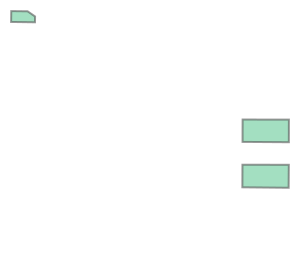

In [52]:
joined

In [53]:
joined.JSON

'{"rings":[[[420568.65039999969,4547565.4802999999],[420568.4227,4547534.5080999993],[420505.99799999967,4547535.1394999996],[420506.0055999998,4547536.1133999992],[420506.07249999978,4547555.2459999993],[420506.1157999998,4547565.6022999994],[420545.41770000011,4547565.5256999992],[420563.03969999962,4547565.4912999999],[420568.65039999969,4547565.4802999999]],[[420568.75549999997,4547626.4134999998],[420568.70289999992,4547595.9470000006],[420506.25009999983,4547596.3747000005],[420506.27689999994,4547612.8342000004],[420506.34970000014,4547626.5360000003],[420568.75549999997,4547626.4134999998]],[[420226.37320000026,4547765.5504000001],[420226.26570000034,4547757.7321000006],[420194.07699999958,4547758.1559999995],[420194.27840000018,4547772.7877999991],[420216.28189999983,4547772.5297999997],[420226.37320000026,4547765.5504000001]]],"spatialReference":{"wkid":26912,"latestWkid":26912}}'

In [80]:
def recursive_union2(shapes):
    if len(shapes) == 2:
        return shapes[0].union(shapes[1])
    else:
        return shapes[0].union(recursive_union2(shapes[1:]))
    

In [81]:
joined = recursive_union2([shape1, shape2, shape3])

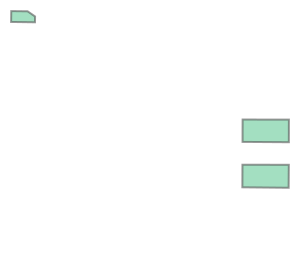

In [82]:
joined

In [83]:
joined.JSON

'{"rings":[[[420568.65039999969,4547565.4802999999],[420568.4227,4547534.5080999993],[420505.99799999967,4547535.1394999996],[420506.0055999998,4547536.1133999992],[420506.07249999978,4547555.2459999993],[420506.1157999998,4547565.6022999994],[420545.41770000011,4547565.5256999992],[420563.03969999962,4547565.4912999999],[420568.65039999969,4547565.4802999999]],[[420568.75549999997,4547626.4134999998],[420568.70289999992,4547595.9470000006],[420506.25009999983,4547596.3747000005],[420506.27689999994,4547612.8342000004],[420506.34970000014,4547626.5360000003],[420568.75549999997,4547626.4134999998]],[[420226.37320000026,4547765.5504000001],[420226.26570000034,4547757.7321000006],[420194.07699999958,4547758.1559999995],[420194.27840000018,4547772.7877999991],[420216.28189999983,4547772.5297999997],[420226.37320000026,4547765.5504000001]]],"spatialReference":{"wkid":26912,"latestWkid":26912}}'

In [84]:
def recursive_union_series(shape_series):
    if shape_series.size == 2:
        return shape_series.iloc[0].union(shape_series.iloc[1])
    else:
        return shape_series.iloc[0].union(recursive_union_series(shape_series.iloc[1:]))
    

In [85]:
shape_series = pd.Series([shape1, shape2, shape3])

In [86]:
joined = recursive_union_series(shape_series)

In [88]:
joined.JSON

'{"rings":[[[420568.65039999969,4547565.4802999999],[420568.4227,4547534.5080999993],[420505.99799999967,4547535.1394999996],[420506.0055999998,4547536.1133999992],[420506.07249999978,4547555.2459999993],[420506.1157999998,4547565.6022999994],[420545.41770000011,4547565.5256999992],[420563.03969999962,4547565.4912999999],[420568.65039999969,4547565.4802999999]],[[420568.75549999997,4547626.4134999998],[420568.70289999992,4547595.9470000006],[420506.25009999983,4547596.3747000005],[420506.27689999994,4547612.8342000004],[420506.34970000014,4547626.5360000003],[420568.75549999997,4547626.4134999998]],[[420226.37320000026,4547765.5504000001],[420226.26570000034,4547757.7321000006],[420194.07699999958,4547758.1559999995],[420194.27840000018,4547772.7877999991],[420216.28189999983,4547772.5297999997],[420226.37320000026,4547765.5504000001]]],"spatialReference":{"wkid":26912,"latestWkid":26912}}'

In [95]:
unions = groups['SHAPE'].agg(recursive_union_series)

In [97]:
unions

PARCEL_ID
100110017    {"rings": [[[420719.6895000003, 4547797.329500...
100120057    {"rings": [[[420857.18319999985, 4547653.16180...
100130023    {"rings": [[[420857.7564000003, 4547803.773700...
100130026    {"rings": [[[420791.6612, 4547867.614800001], ...
100260028    {"rings": [[[419551.4678999996, 4547918.3397],...
                                   ...                        
116940015    {"rings": [[[420441.2006999999, 4546549.313100...
116940016    {"rings": [[[420409.4713000003, 4546565.583799...
116940017    {"rings": [[[420418.3342000004, 4546548.870200...
116940018    {"rings": [[[420435.6118000001, 4546535.106899...
117840026    {"rings": [[[420862.5700000003, 4547324.430600...
Name: SHAPE, Length: 89, dtype: geometry

In [98]:
dups

,OBJECTID,COUNTY_NAME,COUNTY_ID,ASSESSOR_SRC,BOUNDARY_SRC,DISCLAIMER,CURRENT_ASOF,PARCEL_ID,SERIAL_NUM,PARCEL_ADD,PARCEL_CITY,TAXEXEMPT_TYPE,TAX_DISTRICT,TOTAL_MKT_VALUE,LAND_MKT_VALUE,PARCEL_ACRES,PROP_CLASS,PRIMARY_RES,HOUSE_CNT,SUBDIV_NAME,BLDG_SQFT,BLDG_SQFT_INFO,FLOORS_CNT,FLOORS_INFO,BUILT_YR,EFFBUILT_YR,CONST_MATERIAL,x,y,SHAPE
116,117,Davis,6,www.co.davis.ut.us/assessor/,www.co.davis.ut.us/recorder/,http://www.utah.gov/disclaimer.html,2020-07-20,100980019,None,801 N 800 EAST,Layton,NO,39,263000.0,86852.0,0.213,Residential,Y,1,None,1204.0,Only above grade areas are counted,1.0,Only above grade floors are counted and only t...,1967.0,None,None,420060.03125,4547173.0,"{""rings"": [[[420040.4182000002, 4547165.5075],..."
153,154,Davis,6,www.co.davis.ut.us/assessor/,www.co.davis.ut.us/recorder/,http://www.utah.gov/disclaimer.html,2020-07-20,100920106,None,857 N SHERWOOD,Layton,NO,39,228000.0,112956.0,0.370,Residential,Y,1,None,1502.0,Only above grade areas are counted,1.0,Only above grade floors are counted and only t...,1955.0,None,None,419662.59375,4547241.0,"{""rings"": [[[419641.93090000004, 4547244.0233]..."
249,250,Davis,6,www.co.davis.ut.us/assessor/,www.co.davis.ut.us/recorder/,http://www.utah.gov/disclaimer.html,2020-07-20,100920104,None,869 SHERWOOD,Layton,NO,39,209000.0,131933.0,0.555,Residential,Y,1,None,1312.0,Only above grade areas are counted,1.0,Only above grade floors are counted and only t...,1955.0,None,None,419675.34375,4547258.0,"{""rings"": [[[419654.7594999997, 4547260.751399..."
252,253,Davis,6,www.co.davis.ut.us/assessor/,www.co.davis.ut.us/recorder/,http://www.utah.gov/disclaimer.html,2020-07-20,100920102,None,,Layton,NO,39,392000.0,92347.0,0.250,Residential,Y,4,None,3312.0,Only above grade areas are counted,2.0,Only above grade floors are counted and only t...,1974.0,None,None,419825.96875,4547442.5,"{""rings"": [[[419815.3699000003, 4547456.669500..."
253,254,Davis,6,www.co.davis.ut.us/assessor/,www.co.davis.ut.us/recorder/,http://www.utah.gov/disclaimer.html,2020-07-20,100920106,None,857 N SHERWOOD,Layton,NO,39,228000.0,112956.0,0.370,Residential,Y,1,None,1502.0,Only above grade areas are counted,1.0,Only above grade floors are counted and only t...,1955.0,None,None,419629.87500,4547259.0,"{""rings"": [[[419609.0368999997, 4547262.6163],..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1998,1999,Davis,6,www.co.davis.ut.us/assessor/,www.co.davis.ut.us/recorder/,http://www.utah.gov/disclaimer.html,2020-07-20,110050030,None,567 N ADAMSWOOD,Layton,NO,39,276000.0,134198.0,0.242,Residential,Y,1,None,1176.0,Only above grade areas are counted,1.0,Only above grade floors are counted and only t...,1976.0,None,None,420286.46875,4546779.5,"{""rings"": [[[420300.94269999955, 4546775.9143]..."
1999,2000,Davis,6,www.co.davis.ut.us/assessor/,www.co.davis.ut.us/recorder/,http://www.utah.gov/disclaimer.html,2020-07-20,110050040,None,722 E SNOW CREEK,Layton,NO,39,276000.0,133312.0,0.209,Residential,Y,1,None,1260.0,Only above grade areas are counted,1.0,Only above grade floors are counted and only t...,1976.0,None,None,420328.15625,4546983.5,"{""rings"": [[[420340.25459999964, 4546994.3835]..."
2016,2017,Davis,6,www.co.davis.ut.us/assessor/,www.co.davis.ut.us/recorder/,http://www.utah.gov/disclaimer.html,2020-07-20,100120057,None,,Layton,COMMON,39,2425.0,2425.0,4.850,Vacant Land,N,None,None,0.0,Only above grade areas are counted,0.0,Only above grade floors are counted and only t...,NaN,None,None,420797.62500,4547509.0,"{""rings"": [[[420738.1911000004, 4547546.0031],..."
2017,2018,Davis,6,www.co.davis.ut.us/assessor/,www.co.davis.ut.us/recorder/,http://www.utah.gov/disclaimer.html,2020-07-20,103190130,None,,Layton,COMMON,39,155.0,155.0,0.310,Vacant Land,N,None,None,0.0,Only above grade areas are counted,0.0,Only above grade floors are counted and only t...,NaN,None,None,420029.00000,4547428.5,"{""rings"": [[[420036.54140000045, 4547452.9

In [2]:
from collections import defaultdict
fields_map = {'foo': 'sum', 'bar': 'sum', 'baz': 'max'}
ops_and_fields = defaultdict(list)
for field, op in fields_map.items():
    ops_and_fields[op].append(field)
ops_and_fields

defaultdict(list, {'sum': ['foo', 'bar'], 'max': ['baz']})

In [6]:
pd.DataFrame(columns=list(fields_map.keys()))

,foo,bar,baz


In [7]:
fields_group_df = pd.DataFrame({
    'key': [1, 1, 1, 2],
    'first': [11, 12, 13, 50],
    'max': [10, 40, 20, 42],
})


In [13]:
fields_group_df.groupby('key')[['first', 'max']].sum()

,first,max
key,,
1,36,70
2,50,42


In [15]:
combined_df = pd.DataFrame(columns=['first', 'max'])
pd.concat([combined_df, fields_group_df.groupby('key')[['first', 'max']].sum()])

,first,max
1,36,70
2,50,42


In [4]:
dup_parcels_df = pd.DataFrame({
    'PARCEL_ID': ['1', '1', '2', '2', '3'],
    'BLDG_SQFT': [100, 100, 150, 0, 200],
    'TOTAL_MKT_VALUE':[50, 50, 25, 0, 40],
    'LAND_MKT_VALUE': [10, 10, 5, 0, 15],
    'PARCEL_ACRES': [.5, .5, .75, .1, 1],
    'foo': ['bar', 'baz', 'bee', 'boo', 'baa']
})
all_fields = list(dup_parcels_df.columns)

In [5]:
grouped = dup_parcels_df.groupby('PARCEL_ID')

In [10]:
group1 = grouped[all_fields].get_group('1')
group2 = grouped[all_fields].get_group('2')
group3 = grouped[all_fields].get_group('3')

In [12]:
grouped['PARCEL_ID'].get_group('1')

0    1
1    1
Name: PARCEL_ID, dtype: object

In [42]:
group1.duplicated(subset=['PARCEL_ACRES', 'TOTAL_MKT_VALUE'], keep=False).all()

True

In [43]:
group2.duplicated(subset=['PARCEL_ACRES', 'TOTAL_MKT_VALUE'], keep=False).all()

False

In [64]:
def _smart_groupby_sum(group_df, sum_fields, test_fields):
    if not group_df.duplicated(subset=test_fields, keep=False).all():  #: if all the rows have identical values in test_fields
        return group_df.iloc[0][sum_fields]
    return group_df[sum_fields].sum()

In [69]:
sum_fields=['BLDG_SQFT', 'TOTAL_MKT_VALUE', 'LAND_MKT_VALUE']
test_fields=['BLDG_SQFT', 'TOTAL_MKT_VALUE', 'LAND_MKT_VALUE', 'PARCEL_ACRES']
summed_df = grouped.agg(_smart_groupby_sum, sum_fields=sum_fields, test_fields=test_fields)[sum_fields]
summed_df

,BLDG_SQFT,TOTAL_MKT_VALUE,LAND_MKT_VALUE
PARCEL_ID,,,
1,200.0,100.0,20.0
2,150.0,25.0,5.0
3,200.0,40.0,15.0


In [70]:
foo_df = pd.DataFrame({
    'PARCEL_ID': ['8'],
    'BLDG_SQFT': [32],
    'TOTAL_MKT_VALUE': [42],
    'LAND_MKT_VALUE': [16],
    'FOO': ['bar'],
})

In [74]:
pd.concat([summed_df, foo_df], join='inner')

,BLDG_SQFT,TOTAL_MKT_VALUE,LAND_MKT_VALUE
1,200.0,100.0,20.0
2,150.0,25.0,5.0
3,200.0,40.0,15.0
0,32.0,42.0,16.0


In [8]:
dup_parcels_df = pd.DataFrame({
    'PARCEL_ID': ['1', '1', '2', '2', '3'],
    'BLDG_SQFT': [100, 100, 150, 0, 200],
    'TOTAL_MKT_VALUE':[50, 50, 25, 0, 40],
    'LAND_MKT_VALUE': [10, 10, 5, 0, 15],
    'PARCEL_ACRES': [.5, .5, .75, .1, 1],
    'foo': ['bar', 'baz', 'bee', 'boo', 'baa']
})
first_row_series =dup_parcels_df.iloc[0, dup_parcels_df.columns.get_indexer(['PARCEL_ID', 'BLDG_SQFT'])]


In [9]:
first_row_series.index

Index(['PARCEL_ID', 'BLDG_SQFT'], dtype='object')

# Dupe testing

In [2]:
from housing_unit_inventory import dissolve

In [3]:
dupes_fc = "C:\\gis\\Projects\\HousingInventory\\HousingInventory.gdb\\davis_test_parcels_dupes"
dupes_df = pd.DataFrame.spatial.from_featureclass(dupes_fc)

In [4]:
fields_map_list =[
    ['PARCEL_ID', 'COUNT'],
    ['TAXEXEMPT_TYPE', 'FIRST'],
    ['TOTAL_MKT_VALUE', 'SUM'],
    ['LAND_MKT_VALUE', 'SUM'],
    ['PARCEL_ACRES', 'SUM'],
    ['PROP_CLASS', 'FIRST'],
    ['PRIMARY_RES', 'FIRST'],
    ['HOUSE_CNT', 'MAX'],
    ['BLDG_SQFT', 'SUM'],
    ['FLOORS_CNT', 'MAX'],
    ['BUILT_YR', 'FIRST'],
    ['EFFBUILT_YR', 'FIRST'],
]
fields_map_dict = {field[0].casefold(): field[1].casefold() for field in fields_map_list}

In [5]:
fields_map_dict

{'parcel_id': 'count',
 'taxexempt_type': 'first',
 'total_mkt_value': 'sum',
 'land_mkt_value': 'sum',
 'parcel_acres': 'sum',
 'prop_class': 'first',
 'primary_res': 'first',
 'house_cnt': 'max',
 'bldg_sqft': 'sum',
 'floors_cnt': 'max',
 'built_yr': 'first',
 'effbuilt_yr': 'first'}

In [6]:
arcpy.management.Dissolve(dupes_fc, 'memory/dissolved', 'PARCEL_ID', fields_map_list, 'MULTI_PART', 'DISSOLVE_LINES')

<Result 'memory\\dissolved'>

In [7]:
arcpy_df = pd.DataFrame.spatial.from_featureclass('memory/dissolved')

In [8]:
arcpy_df

,OBJECTID,parcel_id,COUNT_parcel_id,FIRST_taxexempt_type,SUM_total_mkt_value,SUM_land_mkt_value,SUM_parcel_acres,FIRST_prop_class,FIRST_primary_res,MAX_house_cnt,SUM_bldg_sqft,MAX_floors_cnt,FIRST_built_yr,FIRST_effbuilt_yr,SHAPE
0,1,None,NaN,None,NaN,NaN,NaN,,None,None,0.0,0.0,NaN,None,"{""rings"": [[[419584.0273000002, 4546558.5713],..."
1,2,100110017,2.0,NO,518000.0,254386.0,0.420,Residential,Y,1,1976.0,1.0,1978.0,None,"{""rings"": [[[420719.6895000003, 4547797.329500..."
2,3,100120057,2.0,COMMON,4850.0,4850.0,9.700,Vacant Land,N,None,0.0,0.0,NaN,None,"{""rings"": [[[420857.18319999985, 4547653.16180..."
3,4,100130023,2.0,NO,516000.0,297584.0,0.636,Residential,Y,1,2096.0,1.0,1988.0,None,"{""rings"": [[[420857.7564000003, 4547803.773700..."
4,5,100130026,2.0,NO,770000.0,319574.0,0.768,Residential,Y,3,7708.0,2.0,1981.0,None,"{""rings"": [[[420791.6612, 4547867.614800001], ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,86,116940015,2.0,NO,776000.0,139000.0,0.254,Residential,Y,1,3542.0,1.0,2013.0,None,"{""rings"": [[[420441.2006999999, 4546549.313100..."
86,87,116940016,2.0,NO,690000.0,139000.0,0.128,Residential,Y,1,3276.0,1.0,2014.0,None,"{""rings"": [[[420409.4713000003, 4546565.583799..."
87,88,116940017,2.0,NO,722000.0,139000.0,0.178,Residential,Y,1,3210.0,1.0,2014.0,None,"{""rings"": [[[420418.3342000004, 4546548.870200..."
88,89,116940018,2.0,NO,782000.0,139000.0,0.228,Residential,Y,1,3504.0,1.0,2014.0,None,"{""rings"": [[[420435.6118000001, 4546535.106899..."


In [9]:
dupe_test_fields = list(fields_map_dict.keys()) + ['parcel_acres']
custom_df = dissolve.dissolve_duplicates_by_dataframe(dupes_df, 'parcel_id', fields_map_dict, dupe_test_fields)

In [10]:
custom_df

,parcel_id,taxexempt_type,total_mkt_value,land_mkt_value,parcel_acres,prop_class,primary_res,house_cnt,bldg_sqft,floors_cnt,built_yr,effbuilt_yr,SHAPE
0,100110017,NO,259000.0,127193.0,0.210,Residential,Y,1,988.0,1.0,1978.0,None,"{'rings': [[[420719.6895000003, 4547797.329500..."
1,100120057,COMMON,2425.0,2425.0,4.850,Vacant Land,N,NaN,0.0,0.0,NaN,None,"{'rings': [[[420857.18319999985, 4547653.16180..."
2,100130023,NO,258000.0,148792.0,0.318,Residential,Y,1,1048.0,1.0,1988.0,None,"{'rings': [[[420857.7564000003, 4547803.773700..."
3,100130026,NO,385000.0,159787.0,0.384,Residential,Y,3,3854.0,2.0,1981.0,None,"{'rings': [[[420791.6612, 4547867.614800001], ..."
4,100260028,NO,435000.0,151118.0,1.120,Residential,Y,2,3812.0,2.0,1977.0,None,"{'rings': [[[419551.4678999996, 4547918.3397],..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
84,116940015,NO,388000.0,69500.0,0.127,Residential,Y,1,1771.0,1.0,2013.0,None,"{'rings': [[[420441.2006999999, 4546549.313100..."
85,116940016,NO,345000.0,69500.0,0.064,Residential,Y,1,1638.0,1.0,2014.0,None,"{'rings': [[[420409.4713000003, 4546565.583799..."
86,116940017,NO,361000.0,69500.0,0.089,Residential,Y,1,1605.0,1.0,2014.0,None,"{'rings': [[[420418.3342000004, 4546548.870200..."
87,116940018,NO,391000.0,69500.0,0.114,Residential,Y,1,1752.0,1.0,2014.0,None,"{'rings': [[[420435.6118000001, 4546535.106899..."


In [11]:
custom_df.columns

Index(['parcel_id', 'taxexempt_type', 'total_mkt_value', 'land_mkt_value',
       'parcel_acres', 'prop_class', 'primary_res', 'house_cnt', 'bldg_sqft',
       'floors_cnt', 'built_yr', 'effbuilt_yr', 'SHAPE'],
      dtype='object')

In [12]:
custom_df[list(fields_map_dict.keys())]

,parcel_id,taxexempt_type,total_mkt_value,land_mkt_value,parcel_acres,prop_class,primary_res,house_cnt,bldg_sqft,floors_cnt,built_yr,effbuilt_yr
0,100110017,NO,259000.0,127193.0,0.210,Residential,Y,1,988.0,1.0,1978.0,None
1,100120057,COMMON,2425.0,2425.0,4.850,Vacant Land,N,NaN,0.0,0.0,NaN,None
2,100130023,NO,258000.0,148792.0,0.318,Residential,Y,1,1048.0,1.0,1988.0,None
3,100130026,NO,385000.0,159787.0,0.384,Residential,Y,3,3854.0,2.0,1981.0,None
4,100260028,NO,435000.0,151118.0,1.120,Residential,Y,2,3812.0,2.0,1977.0,None
...,...,...,...,...,...,...,...,...,...,...,...,...
84,116940015,NO,388000.0,69500.0,0.127,Residential,Y,1,1771.0,1.0,2013.0,None
85,116940016,NO,345000.0,69500.0,0.064,Residential,Y,1,1638.0,1.0,2014.0,None
86,116940017,NO,361000.0,69500.0,0.089,Residential,Y,1,1605.0,1.0,2014.0,None
87,116940018,NO,391000.0,69500.0,0.114,Residential,Y,1,1752.0,1.0,2014.0,None


In [16]:
custom_df['floors_cnt'].round?

In [ ]:
custom_df['floors_cnt'].round

In [15]:
custom_df['floors_cnt'].round(ndigits=None)

TypeError: round() got an unexpected keyword argument 'ndigits'

In [2]:
import arcgis

In [3]:
GeoAccessor.to_featureclass?

In [11]:
dup_parcels_df = pd.DataFrame({
    'PARCEL_ID': ['1', '1', '2', '2', '2'],
    'BLDG_SQFT': [100, 100, 150, 150, 200],
    'TOTAL_MKT_VALUE':[50, 50, 25, 0, 40],
    'LAND_MKT_VALUE': [10, 10, 5, 0, 15],
    'PARCEL_ACRES': [.5, .5, .75, .1, 1],
    'foo': ['bar', 'baz', 'bee', 'boo', 'baa']
})
groupby = dup_parcels_df.groupby('PARCEL_ID')
sq_ft_series = groupby['BLDG_SQFT'].agg(pd.Series.mode).rename('NOTE')

In [12]:
sq_ft_series

PARCEL_ID
1    100
2    150
Name: NOTE, dtype: int64

In [17]:
oug_id = pd.DataFrame({
    'foo': [1, 2, 3, 4, 5]
})

oug_id.insert(0, column='id', value=range(990000, 990000+len(oug_id)))

In [18]:
oug_id

,id,foo
0,990000,1
1,990001,2
2,990002,3
3,990003,4
4,990004,5


# Series mode testing

In [2]:
test_df = pd.DataFrame({
    'group': [1, 1, 2, 3],
    'data': ['foo', 'bar', 'bee', 'baz'],
})


In [7]:
groupby = test_df.groupby('group')
modes = groupby['data'].agg(pd.Series.mode)

In [6]:
groupby['data'].get_group(1)

0    foo
1    bar
Name: data, dtype: object

In [14]:
modes.iloc[0]

array(['bar', 'foo'], dtype=object)

In [13]:
modes.iloc[1]

'bee'

In [15]:
len(modes.iloc[0])

2

In [16]:
multimodes = modes.iloc[0]

In [17]:
type(multimodes)

numpy.ndarray

In [19]:
multimodes.size

2

In [20]:
single_mode = modes.iloc[1]

In [21]:
single_mode

'bee'

In [22]:
type(single_mode)

str

In [28]:
test_series = pd.Series([3, 2, 4])

In [29]:
test_series.size

3

In [31]:
single = test_series.iloc[0:1]

In [32]:
type(single)

pandas.core.series.Series

# Unit count 0 and null testing

In [33]:
parcels_df = pd.DataFrame({
    'PARCEL_ID': [1, 2],
    'SUBTYPE': ['single_family', 'single_family'],
    'UNIT_COUNT': [0, np.nan],
    'NOTE': ['', ''],
    'HOUSE_CNT': [1, 1],
})

In [39]:
zero_or_null_unit_counts = (parcels_df['UNIT_COUNT'] == 0) | (parcels_df['UNIT_COUNT'].isna())
zero_or_null_unit_counts

0    True
1    True
Name: UNIT_COUNT, dtype: bool

In [37]:
parcels_df['UNIT_COUNT'].isna()

0    False
1     True
Name: UNIT_COUNT, dtype: bool

In [41]:
parcels_df['PARCEL_ID'] = parcels_df['PARCEL_ID'].astype(str)

In [43]:
parcels_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   PARCEL_ID   2 non-null      object 
 1   SUBTYPE     2 non-null      object 
 2   UNIT_COUNT  1 non-null      float64
 3   NOTE        2 non-null      object 
 4   HOUSE_CNT   2 non-null      int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 208.0+ bytes


# list membership testing

In [6]:
cols = ['foo', 'bar']
cols_set = set(cols)

In [7]:
cols_set.update(['SHAPE', 'key'])

In [8]:
cols_set

{'SHAPE', 'bar', 'foo', 'key'}

In [9]:
cols_set.update(['foo', 'key'])

In [10]:
cols_set

{'SHAPE', 'bar', 'foo', 'key'}

In [13]:
test_df = pd.DataFrame(columns=['foo', 'bar', 'baz'])

In [14]:
test_df

,foo,bar,baz


In [16]:
test_df.reindex(columns={'foo', 'baz', 'boo'})

,foo,boo,baz


In [21]:
new_cols = set(cols)
new_cols.update(['foo', 'baz'])
print(new_cols)

{'foo', 'bar', 'baz'}


In [22]:
test_df

,foo,bar,baz


In [23]:
test_df.rename(columns={'foo': 'FOO'})

,FOO,bar,baz


In [24]:
test_df

,foo,bar,baz


# test against census

In [26]:
def compare_to_census(evaluated_df, census_blocks_df, outpath):
    evaluated_block_unit_counts = evaluated_df.groupby('BLOCK_FIPS').sum('UNIT_COUNT')
    joined_df = evaluated_block_unit_counts.join(census_blocks_df, how='left', left_on='BLOCK_FIPS', right_on='geoid20')
    return joined_df

In [2]:
evaluated_df = pd.DataFrame.spatial.from_featureclass(r'c:\gis\projects\housinginventory\housinginventory.gdb\davis2020_8a')

In [24]:
evaluated_df

,OBJECTID,UNIT_ID,TYPE,SUBTYPE,IS_OUG,UNIT_COUNT,DUA,ACRES,TOT_BD_FT2,TOT_VALUE,APX_BLT_YR,BLT_DECADE,CITY,COUNTY,SUBCOUNTY,PARCEL_ID,BLOCK_FIPS,TRACT_FIPS,SHAPE
0,1,None,multi_family,apartment,Yes,99.0,17.219341,5.749349,79004.0,9145682.0,1985.0,1980.0,North Salt Lake,DAVIS,South Davis County,990001,490111269024007,49011126902,"{""rings"": [[[424333.36899999995, 4523310.09830..."
1,2,None,multi_family,townhome,Yes,4.0,7.750787,0.516077,6531.0,1109190.0,1983.0,1980.0,Bountiful,DAVIS,South Davis County,990002,490111269024003,49011126902,"{""rings"": [[[424488.7642000001, 4523372.6039],..."
2,3,None,multi_family,townhome,Yes,8.0,9.839647,0.813037,8331.0,2089240.0,1986.0,1980.0,Bountiful,DAVIS,South Davis County,990003,490111269024004,49011126902,"{""rings"": [[[424697.5943, 4523485.3116], [4246..."
3,4,None,multi_family,townhome,Yes,4.0,9.278807,0.431090,6010.0,1002175.0,2007.0,2000.0,Bountiful,DAVIS,South Davis County,990004,490111269024004,49011126902,"{""rings"": [[[424565.1163999997, 4523564.0053],..."
4,5,None,multi_family,townhome,Yes,58.0,23.025240,2.518975,80806.0,12071518.0,2019.0,2010.0,Woods Cross,DAVIS,South Davis County,990006,490111270063003,49011127006,"{""rings"": [[[424196.7867999999, 4524233.9915],..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84145,84146,None,multi_family,mobile_home_park,No,1.0,2.830484,0.353296,2128.0,258000.0,2018.0,2010.0,Clearfield,DAVIS,North Davis County,140700006,490111255022011,49011125502,"{""rings"": [[[412886.21410000045, 4552382.91599..."
84146,84147,None,multi_family,mobile_home_park,No,1.0,1.236541,0.808708,1974.0,276000.0,1996.0,1990.0,South Weber,DAVIS,North Davis County,131580001,490111251032006,49011125103,"{""rings"": [[[418650.6288999999, 4555242.534299..."
84147,84148,None,multi_family,mobile_home_park,No,1.0,1.000904,0.999097,1620.0,235000.0,1996.0,1990.0,None,DAVIS,North Davis County,141750016,490111253074022,49011125307,"{""rings"": [[[406741.01800000016, 4555763.89729..."
84148,84149,None,multi_family,mobile_home_park,No,125.0,11.573119,10.800891,0.0,5500000.0,1962.0,1960.0,Clearfield,DAVIS,North Davis County,120200161,490111255021015,49011125502,"{""rings"": [[[413764.7653999999, 4552188.4113],..."


In [3]:
census_df = pd.DataFrame.spatial.from_featureclass(r'c:\gis\projects\housinginventory\opensgid.agrc.utah.gov.sde\opensgid.demographic.census_blocks_2020')


In [5]:
tracts_df = pd.DataFrame.spatial.from_featureclass(r'c:\gis\projects\housinginventory\opensgid.agrc.utah.gov.sde\opensgid.demographic.census_tracts_2020')


In [43]:
tracts_df.set_index('geoid20', inplace=True)

In [44]:
tracts_df

,xid,statefp20,countyfp20,tractce20,name20,namelsad20,mtfcc20,funcstat20,aland20,awater20,intptlat20,intptlon20,pop100,hu100,SHAPE
geoid20,,,,,,,,,,,,,,,
49049000901,1,49,049,000901,9.01,Census Tract,G5020,S,1.686016e+06,0.0,+40.3051285,-111.6922978,5559,1958,"{""rings"": [[[440398.4642000003, 4462604.4892],..."
49049002500,2,49,049,002500,25,Census Tract,G5020,S,1.034541e+06,0.0,+40.2296149,-111.6497278,4218,1653,"{""rings"": [[[444113.66309999954, 4453163.1712]..."
49049003401,3,49,049,003401,34.01,Census Tract,G5020,S,9.085765e+06,23788.0,+40.0560227,-111.7122570,3896,1233,"{""rings"": [[[436447.3992999997, 4432868.571], ..."
49049010210,4,49,049,010210,102.10,Census Tract,G5020,S,1.581048e+07,0.0,+40.4005884,-111.7306856,5868,1592,"{""rings"": [[[434385.5806999998, 4474166.1998],..."
49049000505,5,49,049,000505,5.05,Census Tract,G5020,S,3.919712e+06,0.0,+40.3700595,-111.7070846,3288,846,"{""rings"": [[[438303.71279999986, 4469684.0035]..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49035111701,712,49,035,111701,1117.01,Census Tract,G5020,S,1.358256e+06,0.0,+40.6934670,-111.8826082,5452,2244,"{""rings"": [[[424945.5695000002, 4504747.2454],..."
49035111903,713,49,035,111903,1119.03,Census Tract,G5020,S,2.072253e+06,0.0,+40.6806830,-111.8627470,4113,1876,"{""rings"": [[[426353.4841, 4503135.8453], [4263..."
49035111905,714,49,035,111905,1119.05,Census Tract,G5020,S,1.167718e+06,0.0,+40.6765749,-111.8744366,3806,1871,"{""rings"": [[[425548.92899999954, 4502917.7248]..."


In [11]:
block_fips = 490111258091001
tract_fips = int(''.join([i for i in str(block_fips)][:11])) 
tract_fips

49011125809

In [19]:
evaluated_df['TRACT_FIPS'] = evaluated_df['BLOCK_FIPS'].apply(lambda x: ''.join([i for i in str(x)][:11]))
evaluated_df

,OBJECTID,UNIT_ID,TYPE,SUBTYPE,IS_OUG,UNIT_COUNT,DUA,ACRES,TOT_BD_FT2,TOT_VALUE,APX_BLT_YR,BLT_DECADE,CITY,COUNTY,SUBCOUNTY,PARCEL_ID,BLOCK_FIPS,TRACT_FIPS,SHAPE
0,1,None,multi_family,apartment,Yes,99.0,17.219341,5.749349,79004.0,9145682.0,1985.0,1980.0,North Salt Lake,DAVIS,South Davis County,990001,490111269024007,49011126902,"{""rings"": [[[424333.36899999995, 4523310.09830..."
1,2,None,multi_family,townhome,Yes,4.0,7.750787,0.516077,6531.0,1109190.0,1983.0,1980.0,Bountiful,DAVIS,South Davis County,990002,490111269024003,49011126902,"{""rings"": [[[424488.7642000001, 4523372.6039],..."
2,3,None,multi_family,townhome,Yes,8.0,9.839647,0.813037,8331.0,2089240.0,1986.0,1980.0,Bountiful,DAVIS,South Davis County,990003,490111269024004,49011126902,"{""rings"": [[[424697.5943, 4523485.3116], [4246..."
3,4,None,multi_family,townhome,Yes,4.0,9.278807,0.431090,6010.0,1002175.0,2007.0,2000.0,Bountiful,DAVIS,South Davis County,990004,490111269024004,49011126902,"{""rings"": [[[424565.1163999997, 4523564.0053],..."
4,5,None,multi_family,townhome,Yes,58.0,23.025240,2.518975,80806.0,12071518.0,2019.0,2010.0,Woods Cross,DAVIS,South Davis County,990006,490111270063003,49011127006,"{""rings"": [[[424196.7867999999, 4524233.9915],..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84145,84146,None,multi_family,mobile_home_park,No,1.0,2.830484,0.353296,2128.0,258000.0,2018.0,2010.0,Clearfield,DAVIS,North Davis County,140700006,490111255022011,49011125502,"{""rings"": [[[412886.21410000045, 4552382.91599..."
84146,84147,None,multi_family,mobile_home_park,No,1.0,1.236541,0.808708,1974.0,276000.0,1996.0,1990.0,South Weber,DAVIS,North Davis County,131580001,490111251032006,49011125103,"{""rings"": [[[418650.6288999999, 4555242.534299..."
84147,84148,None,multi_family,mobile_home_park,No,1.0,1.000904,0.999097,1620.0,235000.0,1996.0,1990.0,None,DAVIS,North Davis County,141750016,490111253074022,49011125307,"{""rings"": [[[406741.01800000016, 4555763.89729..."
84148,84149,None,multi_family,mobile_home_park,No,125.0,11.573119,10.800891,0.0,5500000.0,1962.0,1960.0,Clearfield,DAVIS,North Davis County,120200161,490111255021015,49011125502,"{""rings"": [[[413764.7653999999, 4552188.4113],..."


In [23]:
# evaluated_block_unit_counts = evaluated_df[['UNIT_COUNT', 'TOT_BD_FT2', 'TOT_VALUE', 'TRACT_FIPS']].groupby('TRACT_FIPS').sum()
# evaluated_block_unit_counts.reset_index(inplace=True)
# joined_df = evaluated_block_unit_counts.merge(census_df, how='left', left_on='BLOCK_FIPS', right_on='geoid20')
# joined_df = evaluated_block_unit_counts.merge(tracts_df, how='left', left_on='TRACT_FIPS', right_on='geoid20')
# joined_df['eval_minus_census'] = joined_df['UNIT_COUNT'] - joined_df['hu100']
# joined_df[['TRACT_FIPS', 'UNIT_COUNT', 'TOT_BD_FT2', 'TOT_VALUE', 'hu100', 'eval_minus_census']]

,TRACT_FIPS,UNIT_COUNT,TOT_BD_FT2,TOT_VALUE,hu100,eval_minus_census
0,49011125102,1437.0,3072593.0,640375956.0,1370,67.0
1,49011125103,2789.0,3409971.0,646685117.0,2406,383.0
2,49011125104,1734.0,3328208.0,661355949.0,1808,-74.0
3,49011125201,4.0,5325.0,770000.0,1085,-1081.0
4,49011125301,2240.0,2449396.0,373239101.0,1879,361.0
...,...,...,...,...,...,...
60,49011127002,3315.0,2845378.0,573284602.0,2788,527.0
61,49011127003,3555.0,5217005.0,951113925.0,2584,971.0
62,49011127005,1163.0,1658469.0,337683310.0,1119,44.0
63,49011127006,1309.0,1690297.0,366642279.0,1316,-7.0


In [30]:
joined_df['eval_minus_census'].describe()

count      65.000000
mean       52.261538
std       277.398984
min     -1081.000000
25%       -24.000000
50%        -3.000000
75%        83.000000
max      1087.000000
Name: eval_minus_census, dtype: float64

In [79]:
avg_sf_dua = evaluated_df[evaluated_df['TYPE'] == 'single_family'][['DUA', 'TRACT_FIPS']].groupby('TRACT_FIPS').mean().rename(columns={'DUA': 'avg_sf_dua'})
avg_mf_dua = evaluated_df[evaluated_df['TYPE'] == 'multi_family'][['DUA', 'TRACT_FIPS']].groupby('TRACT_FIPS').mean().rename(columns={'DUA': 'avg_mf_dua'})
avg_all_dua = evaluated_df[['DUA', 'TRACT_FIPS']].groupby('TRACT_FIPS').mean().rename(columns={'DUA': 'avg_all_dua'})
sf_avgs = evaluated_df[evaluated_df['TYPE'] == 'single_family'][['TOT_BD_FT2', 'TOT_VALUE', 'TRACT_FIPS']].groupby('TRACT_FIPS').mean().rename(columns={'TOT_BD_FT2': 'avg_sf_sqft', 'TOT_VALUE': 'avg_sf_value'})

In [82]:
sf_avgs

,avg_sf_sqft,avg_sf_value
TRACT_FIPS,,
49011125102,2332.119658,488771.108780
49011125103,1823.037267,359701.435473
49011125104,1916.095012,384489.442399
49011125201,1331.250000,192500.000000
49011125301,1327.951734,210154.553365
...,...,...
49011127002,1498.743846,310289.855385
49011127003,3147.851380,575919.498938
49011127005,1501.965829,318471.532663


In [36]:
avg_sf_dua.info()

<class 'pandas.core.frame.DataFrame'>
Index: 65 entries, 49011125102 to 49011127100
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   DUA     65 non-null     float64
dtypes: float64(1)
memory usage: 3.1+ KB


In [29]:
avg_mf_dua

,DUA
TRACT_FIPS,
49011125102,8.959006
49011125103,9.776475
49011125104,4.959726
49011125301,17.514660
49011125304,11.344371
...,...
49011127002,18.796288
49011127003,13.310026
49011127005,6.307283


In [32]:
avg_all_dua

,DUA
TRACT_FIPS,
49011125102,2.930751
49011125103,3.991556
49011125104,3.275919
49011125201,4.879382
49011125301,6.009973
...,...
49011127002,7.289234
49011127003,3.973670
49011127005,4.933484


In [74]:
pre_2020_unit_count = evaluated_df[evaluated_df['APX_BLT_YR']<2019][['TRACT_FIPS', 'UNIT_COUNT']].groupby('TRACT_FIPS').sum().rename(columns={'UNIT_COUNT': 'pre_2020_unit_count'})


In [41]:
sums = evaluated_df[['UNIT_COUNT', 'TOT_BD_FT2', 'TOT_VALUE', 'TRACT_FIPS']].groupby('TRACT_FIPS').sum()
sums

,UNIT_COUNT,TOT_BD_FT2,TOT_VALUE
TRACT_FIPS,,,
49011125102,1437.0,3072593.0,640375956.0
49011125103,2789.0,3409971.0,646685117.0
49011125104,1734.0,3328208.0,661355949.0
49011125201,4.0,5325.0,770000.0
49011125301,2240.0,2449396.0,373239101.0
...,...,...,...
49011127002,3315.0,2845378.0,573284602.0
49011127003,3555.0,5217005.0,951113925.0
49011127005,1163.0,1658469.0,337683310.0


In [80]:
joined_df = pd.concat([tracts_df[['SHAPE','pop100', 'hu100']], sums, pre_2020_unit_count, avg_sf_dua, avg_mf_dua, avg_all_dua, sf_avgs], axis=1).dropna(subset=['UNIT_COUNT'])

In [76]:
joined_df

,SHAPE,pop100,hu100,UNIT_COUNT,TOT_BD_FT2,TOT_VALUE,pre_2020_unit_count,avg_sf_dua,avg_mf_dua,avg_all_dua
49011126105,"{""rings"": [[[420548.44379999954, 4542046.6951]...",6436,1725,1710.0,2968308.0,628863075.0,1705.0,4.590069,9.083200,4.674496
49011126203,"{""rings"": [[[423310.45990000013, 4540364.6054]...",4517,1348,1377.0,3187951.0,702569185.0,1363.0,3.104565,12.485257,3.357436
49011126304,"{""rings"": [[[421634.90139999986, 4528929.0152]...",6955,2255,2041.0,3977709.0,776912081.0,1990.0,3.883259,7.697844,3.897030
49011126306,"{""rings"": [[[424937.8322999999, 4528810.0287],...",7585,2885,3062.0,4299428.0,838234962.0,3061.0,4.231680,12.979035,4.678872
49011125501,"{""rings"": [[[410618.6292000003, 4551550.2971],...",6741,2075,2267.0,2490973.0,490812310.0,2198.0,4.712643,12.615679,4.908869
...,...,...,...,...,...,...,...,...,...,...
49011126002,"{""rings"": [[[415357.89580000006, 4544309.07190...",7994,2199,2321.0,4021579.0,814021612.0,2028.0,3.863330,6.715384,3.870199
49011125807,"{""rings"": [[[418245.6966000004, 4549660.442700...",3675,1370,2457.0,975310.0,189682207.0,2387.0,4.317042,26.660195,4.828717
49011127100,"{""rings"": [[[420265.4735000003, 4543427.589199...",8538,2789,2933.0,7081392.0,886577336.0,2925.0,3.702446,11.042633,4.063675
49011126001,"{""rings"": [[[416755.3304000003, 4547519.9706],...",5835,2156,2166.0,2079635.0,362014090.0,1980.0,4.861735,34.330956,6.020926


In [81]:
joined_df['eval_minus_census'] = joined_df['pre_2020_unit_count'] - joined_df['hu100']
joined_df

,SHAPE,pop100,hu100,UNIT_COUNT,TOT_BD_FT2,TOT_VALUE,pre_2020_unit_count,avg_sf_dua,avg_mf_dua,avg_all_dua,avg_sf_sqft,avg_sf_value,eval_minus_census
49011126105,"{""rings"": [[[420548.44379999954, 4542046.6951]...",6436,1725,1710.0,2968308.0,628863075.0,1705.0,4.590069,9.083200,4.674496,1747.046679,371002.261520,-20.0
49011126203,"{""rings"": [[[423310.45990000013, 4540364.6054]...",4517,1348,1377.0,3187951.0,702569185.0,1363.0,3.104565,12.485257,3.357436,2736.220733,608505.589812,15.0
49011126304,"{""rings"": [[[421634.90139999986, 4528929.0152]...",6955,2255,2041.0,3977709.0,776912081.0,1990.0,3.883259,7.697844,3.897030,2021.450483,406785.641908,-265.0
49011126306,"{""rings"": [[[424937.8322999999, 4528810.0287],...",7585,2885,3062.0,4299428.0,838234962.0,3061.0,4.231680,12.979035,4.678872,1875.762449,395481.760000,176.0
49011125501,"{""rings"": [[[410618.6292000003, 4551550.2971],...",6741,2075,2267.0,2490973.0,490812310.0,2198.0,4.712643,12.615679,4.908869,1431.379376,282790.426480,123.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
49011126002,"{""rings"": [[[415357.89580000006, 4544309.07190...",7994,2199,2321.0,4021579.0,814021612.0,2028.0,3.863330,6.715384,3.870199,1839.123129,372267.739739,-171.0
49011125807,"{""rings"": [[[418245.6966000004, 4549660.442700...",3675,1370,2457.0,975310.0,189682207.0,2387.0,4.317042,26.660195,4.828717,1721.898438,322307.312500,1017.0
49011127100,"{""rings"": [[[420265.4735000003, 4543427.589199...",8538,2789,2933.0,7081392.0,886577336.0,2925.0,3.702446,11.042633,4.063675,1923.078675,406423.836439,136.0
49011126001,"{""rings"": [[[416755.3304000003, 4547519.9706],...",5835,2156,2166.0,2079635.0,362014090.0,1980.0,4.861735,34.330956,6.020926,1236.082803,237015.222020,-176.0


In [83]:
joined_df.spatial.to_featureclass(r'c:\gis\projects\housinginventory\housinginventory.gdb\davis2020_8a_bytract')

'c:\\gis\\Projects\\housinginventory\\housinginventory.gdb\\davis2020_8a_bytract'

# split OUGs on census blocks

In [2]:
census_df = pd.DataFrame.spatial.from_featureclass(r'c:\gis\projects\housinginventory\opensgid.agrc.utah.gov.sde\opensgid.demographic.census_blocks_2020')


In [3]:
input_dir_path = Path(r'c:\gis\git\housing-unit-inventory\Parcels\2020-Davis\Inputs')
common_areas_fc = input_dir_path / r'Common_Areas.gdb/Common_Areas_Reviewed'
common_areas_df = pd.DataFrame.spatial.from_featureclass(common_areas_fc)


In [6]:
common_areas_df.spatial.plot()

MapView(layout=Layout(height='400px', width='100%'))

In [8]:
common_areas_df.spatial.overlay(census_df, op='intersection')

ValueError: Spatially enabled DataFrame must be the same geometry type.

In [9]:
common_areas_df.spatial.geometry_type

['polygon', None]

In [10]:
census_df.spatial.geometry_type

['polygon']

In [13]:
common_areas_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 574 entries, 0 to 573
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   OBJECTID      574 non-null    int64   
 1   SUBTYPE_WFRC  268 non-null    object  
 2   Review        574 non-null    int64   
 3   MERGE_SRC     573 non-null    object  
 4   TYPE_WFRC     574 non-null    object  
 5   SHAPE         573 non-null    geometry
dtypes: geometry(1), int64(2), object(3)
memory usage: 27.0+ KB
